In [1]:
from sstadex import Macromodel, Test, cs_pmos, Primitive, dfs, simplediffpair, cm_pmos, spice_sim
from sympy import Symbol
from sympy import lambdify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

# LDO with IHP-SG13G2 low voltage, simple topology

In [2]:
## Exploration parameters

N_points = 10
lengths_nmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
lengths_pmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

lut_file = "../../LUTs/gf_LUT_03v3.npy"
lut_w = 20e-6

## Electrical parameters

Vout = 1.2                                      # LDO output voltage
Vin = 1.8                                       # LDO supply voltage
Vref = 0.9                                      # LDO voltage reference
IL = 5e-3                                     # Load current
CL = 0.5e-12                                    # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.98
psrr_condition = -70
estability_condition = 60
linereg_condition = 0.5
loadreg_condition = 0.7
#iq_condition = 20e-6
size_condition = 1e-3

I_bias = 5e-6
I_amp1 = 10e-6 # considering the two branches of differential pair
I_amp2 = 10e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp1-I_amp2-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

Value
Vout    1.200000e+00
Vin     1.800000e+00
Vref    9.000000e-01
IL      5.000000e-03
CL      5.000000e-13
RL      2.400000e+02
Iq_max  1.000000e-04
Ib_pt   7.500000e-05
R1      4.000000e+03
R2      1.200000e+04

# Step 1: Pre-exploration

## Macromodels Definition

In [3]:
Vota = np.linspace(Vout-0.8, Vout+0.5, N_points)
Vota_1stage = np.linspace(Vout-0.3, Vout+0.5, 5)

In [94]:
LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_2stage"), Symbol("L_2stage"),
        Symbol("vin_2stage"),
        Symbol('W_cs_2stage'), Symbol('L_cs_2stage'),
        Symbol('vgs_cs_2stage'),
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("vout_1stage"),
        Symbol("W_al"), Symbol("L_al"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs'),
        Symbol("W_pt"), Symbol("L_pt"),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "Vota": Vota,
        "Il": IL+Ib_pt}
    )

OTA_macro = Macromodel(
    name = 'OTA_macro',
    outputs = [
        Symbol("W_2stage"), Symbol("L_2stage"),
        Symbol("vin_2stage"),
        Symbol('W_cs_2stage'), Symbol('L_cs_2stage'),
        Symbol('vgs_cs_2stage'),
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("vout_1stage"),
        Symbol("W_al"), Symbol("L_al"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs'),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["Vota"],
        "Vota_1stage": Vota_1stage,
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points)}
    )

OTA_2stage_macro = Macromodel(
    name = 'OTA_2stage_macro',
    outputs = [
        Symbol("W_2stage"), Symbol("L_2stage"),
        Symbol("vin_2stage"),
        Symbol('W_cs_2stage'), Symbol('L_cs_2stage'),
        Symbol('vgs_cs_2stage')],
    electrical_parameters = {
        "Vdd": OTA_macro.electrical_parameters["Vdd"],
        "Vin": OTA_macro.electrical_parameters["Vota_1stage"],
        "Vout": OTA_macro.electrical_parameters["Vout"],
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra_2stage'): np.logspace(3, 7, 5),
        Symbol('gma_2stage'): np.logspace(-5, -2, 5),
        Symbol('Cin_2stage'): np.logspace(-16, -11, 5)}
    )

OTA_1stage_macro = Macromodel(
    name = 'OTA_1stage_macro',
    outputs = [
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("vout_1stage"),
        Symbol("W_al"), Symbol("L_al"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')],
    electrical_parameters = {
        "Vdd": OTA_macro.electrical_parameters["Vdd"],
        "Vref": OTA_macro.electrical_parameters["Vref"],
        "Vout": OTA_macro.electrical_parameters["Vota_1stage"],
        "Il": I_amp1},
    macromodel_parameters={
        Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
        Symbol('gma_1stage'): np.logspace(-5, -2, N_points)}
    ) 

## Testbenches

### LDO testbenches

In [5]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(100/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*3.3)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [-300]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

### OTA testbenches

In [6]:
gain_OTA = Test()
gain_OTA.name = "gain_OTA"
gain_OTA.tf = ["vout", "vpos"]
gain_OTA.netlist = "OpAmp_2stage"
gain_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("I_amp2"): 0,
    Symbol("s"): 0}

gain_OTA.opt_goal = "max"
gain_OTA.conditions = {"min": [10**(-100/20)]}
gain_OTA.variables = {}
gain_OTA.out_def = {"eval": gain_OTA.tf}

#########################################################

phase_margin_OTA = Test()
phase_margin_OTA.name = "phase_margin_OTA"
phase_margin_OTA.tf = ["vout", "vpos"]
phase_margin_OTA.netlist = "OpAmp_2stage"
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): 1e-12}

phase_margin_OTA.opt_goal = "min"
phase_margin_OTA.conditions = {"min": [0]}
phase_margin_OTA.variables = {}
phase_margin_OTA.out_def = {"pm": phase_margin_OTA.tf}

##########################################################

rout_OTA = Test()
rout_OTA.name = "rout_OTA"
rout_OTA.target_param = Symbol("Ra")
rout_OTA.tf = ["vout", "vr"]
rout_OTA.netlist = "OpAmp_2stage_rout"
rout_OTA.parametros = {
    Symbol("Vpos"): 0,
    Symbol("Vr"): 1,
    Symbol("s"): 0,
    Symbol("Rr"): 1000,
    Symbol("Cin_pt"): 1e-12}

rout_OTA.opt_goal = "max"
rout_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_OTA.variables = {}
rout_OTA.out_def = {"eval": rout_OTA.tf}

##########################################################

gm_OTA = Test()
gm_OTA.target_param = Symbol("gma")
gm_OTA.name = "gm_OTA"
gm_OTA.tf = ["vout", "vpos"]
gm_OTA.netlist = "OpAmp_2stage"
gm_OTA.composed = 1
gm_OTA.out_def = {"divide": [gain_OTA, rout_OTA]}
gm_OTA.opt_goal = "max"
gm_OTA.conditions = {"min": [0.000000001]}

### OTA 2stage Testbenches

In [7]:
gain_2stage_OTA = Test()
gain_2stage_OTA.tf = ("vout", "vin")
gain_2stage_OTA.name = "gain_2stage"
gain_2stage_OTA.netlist = "ota_2stage_v2"
gain_2stage_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("V2"): 1,
    Symbol("s"): 0,
    Symbol("Cin_pt"): 1e-12}
gain_2stage_OTA.opt_goal = "max"
gain_2stage_OTA.conditions = {"min": [1]}
gain_2stage_OTA.variables = {}
gain_2stage_OTA.out_def = {"eval": gain_2stage_OTA.tf}

##################################################################

rout_2stage_OTA = Test()
rout_2stage_OTA.name = "rout_2stage"
rout_2stage_OTA.target_param = Symbol("Ra_2stage")
rout_2stage_OTA.tf = ["vout", "vr"]
rout_2stage_OTA.netlist = "ota_2stage_rout_v2"
rout_2stage_OTA.parametros = {Symbol("V1"): 0,
                              Symbol("V2"): 0,
                                Symbol("Vr"): 1,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cin_pt"): 1e-12}

rout_2stage_OTA.opt_goal = "max"
rout_2stage_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_2stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

##################################################################

gm_2stage_OTA = Test()
gm_2stage_OTA.target_param = Symbol("gma_2stage")
gm_2stage_OTA.name = "gm_2stage"
gm_2stage_OTA.tf = ["vout", "vin"]
gm_2stage_OTA.netlist = "ota_2stage_v2"
gm_2stage_OTA.composed = 1
gm_2stage_OTA.out_def = {"divide": [gain_2stage_OTA, rout_2stage_OTA]}
gm_2stage_OTA.opt_goal = "max"
gm_2stage_OTA.conditions = {"min": [0.000000001]}

### OTA 1stage Testbenches

In [8]:
gain_1stage_OTA = Test()
gain_1stage_OTA.tf = ("vout", "vpos")
gain_1stage_OTA.name = "gain_1stage"
gain_1stage_OTA.netlist = "ota_1stage"
gain_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0}
gain_1stage_OTA.opt_goal = "max"
gain_1stage_OTA.conditions = {"min": [10**(-100/20)]}
gain_1stage_OTA.variables = {}
gain_1stage_OTA.out_def = {"eval": gain_1stage_OTA.tf}

##################################################################

psrr_1stage_OTA = Test()
psrr_1stage_OTA.tf = ("vout", "vdd")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_1stage"
psrr_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 1,
    Symbol("V_n"): 0,
    Symbol("V_p"): 0,
    Symbol("I2"): 0,
    Symbol("s"): 0}
psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [0.0000001]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

##################################################################

rout_1stage_OTA = Test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_1stage_rout"
rout_1stage_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

##################################################################

gm_1stage_OTA = Test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_1stage"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [gain_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"
gm_1stage_OTA.conditions = {"min": [9.999999999999999e-6]}

## Primitives definition

### LDO primitives

In [9]:
LDO_macro.electrical_parameters["Vota"]

array([0.4       , 0.54444444, 0.68888889, 0.83333333, 0.97777778,
       1.12222222, 1.26666667, 1.41111111, 1.55555556, 1.7       ])

In [10]:
LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"]

-0.6000000000000001

In [11]:
pt = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["Vota"]-Vin, 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths_pmos, 
        '2d_var': ['length', 'vgs']})

pt_df = pt.build()

mask = (pt_df["width"]>5e-6) & (pt_df["width"]<15e-3)

pt_df = pt_df[mask]

pt.parameters = {
    Symbol('gm_pt'): pt_df['gm'].values,
    Symbol('Ro_pt'): pt_df['Ro'].values,
    Symbol("Cgg_pt"): pt_df['cgg'].values,
    Symbol("Cgd_pt"): np.abs(pt_df['cgd'].values),  
    Symbol("Cin_pt"): pt_df['cgg'].values+np.abs(pt_df["cgd"].values)*pt_df["gm"].values*pt_df["Ro"].values,
    Symbol("dropout"): 2/(pt_df["gm"]/pt.inputs['il']),
    Symbol('Vota'): np.tile(LDO_macro.electrical_parameters["Vota"], 5)[mask]}

pt.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"],
            vgs=(-2.5, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = Ib_pt/pt.W.flatten()

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=pt.L.flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vgs_2 = np.diag(vgs_2)
print("Values of Vgs_pt when there is no load: ", vgs_2)
##

vout_2stage_wc = vgs_2

pt_wc = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-2, -0.1, 0.01), 
        'vgs': vout_2stage_wc, 
        'il': Ib_pt,
        'length': pt.L.flatten(), 
        '2d_var': ['length', 'vgs']})

pt_wc_df = pt_wc.build()

pt_wc.parameters = {
    Symbol('gm_pt'): pt_wc_df["gm"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol('Ro_pt'): pt_wc_df["Ro"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol("Cgg_pt"): pt_wc_df["cgg"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol("Cgd_pt"): np.abs(pt_wc_df["cgd"].values.reshape(50,-1).diagonal().flatten()[mask]),
    Symbol("dropout"): 2/(pt_wc_df["gm"].values.reshape(50,-1).diagonal().flatten()[mask]/pt_wc.inputs['il']),
    Symbol("Cin_pt"): pt_wc_df["cgg"].values.reshape(50,-1).diagonal().flatten()[mask]
                        +np.abs(pt_wc_df["cgd"].values.reshape(50,-1).diagonal().flatten()[mask])
                        *pt_wc_df["gm"].values.reshape(50,-1).diagonal().flatten()[mask]*pt_wc_df["Ro"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol('Vota'): Vin+vout_2stage_wc[mask]}

pt_wc.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

length
vgs
0


Values of Vgs_pt when there is no load:  [-0.79822892 -0.7737634  -0.74212668 -0.69654108 -0.62104845 -0.50735599
 -0.38636305 -0.11040153         nan         nan -0.81059682 -0.7841227
 -0.75054833 -0.70268365 -0.6242     -0.50867747 -0.31580849 -0.10244493
         nan         nan -0.80499126 -0.77804472 -0.74444594 -0.69742662
 -0.62124885 -0.50731728 -0.2119297  -0.10027211         nan         nan
 -0.80139326 -0.77432421 -0.74082453 -0.69435327 -0.61950623 -0.50681843
 -0.14532903         nan         nan         nan -0.79947371 -0.77235892
 -0.73892426 -0.69273853 -0.6185787  -0.51256311 -0.12145614         nan
         nan         nan]
length
vgs
0


In [12]:
pt.outputs[Symbol("W_pt")]

array([0.00030893, 0.00048443, 0.0009078 , 0.00241088, 0.01391776,
       0.00069929, 0.00113496, 0.00221162, 0.00619547, 0.00148736,
       0.00242249, 0.0046996 , 0.01285472, 0.00309754, 0.005044  ,
       0.00974157, 0.00633539, 0.01031241])

### OTA primitives

In [13]:
vs = np.linspace(0.3, 0.8, 5)

Cc = np.logspace(-13, -10, 3)
Rc = np.logspace(3, 5, 3)

mesh = np.meshgrid(Cc, Rc)

Cc_primitive = Primitive(parameters={Symbol("Cc"): mesh[0].flatten(),
                                     Symbol("Rc"): mesh[1].flatten()})
Cc_primitive.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, len(mesh[0].flatten()))}

In [14]:
Cc = np.logspace(-13, -12, 3)
Rc = np.logspace(3, 4, 3)

mesh = np.meshgrid(Cc, Rc)

Cc_primitive_LDO = Primitive(parameters={Symbol("Cc"): mesh[0].flatten(),
                                     Symbol("Rc"): mesh[1].flatten()})
Cc_primitive_LDO.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, len(mesh[0].flatten()))}

### OTA 2stage primitives

In [15]:
OTA_2stage_macro.electrical_parameters["Vin"]

array([0.9, 1.1, 1.3, 1.5, 1.7])

In [16]:
vout_2stage = 0.688-Vin
vout_1stage = OTA_2stage_macro.electrical_parameters["Vin"] - Vin
Cin_pt = 4.84e-11

stage2_t = cs_pmos()
stage2_t.parameters = {
    Symbol('gm_2stage'): [],
    Symbol('Ro_2stage'): [],
    Symbol('Cin_2stage'): [],
    }

stage2_t.outputs = {
    Symbol("W_2stage"): [],
    Symbol("L_2stage"): [],
    Symbol("vin_2stage"): []}

for vds, vgs, Cout in zip(np.repeat(vout_2stage, 5) ,vout_1stage, np.repeat(Cin_pt, 5)):

    stage2_t_aux = cs_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='pmos',
        inputs={
            'vds_lut': vds, 
            'vgs_lut': (-1.8, -0.1, 0.01), 
            'vgs': vgs, 
            'il': OTA_2stage_macro.electrical_parameters["Il"],
            'length': lengths_pmos, 
            '2d_var': ['length', 'vgs']})

    stage2_t_aux.build()

    print(stage2_t_aux.L)
    print(stage2_t_aux.W)
    print(vds)
    print(vgs)

    stage2_t.parameters[Symbol('gm_2stage')].append(np.asarray(stage2_t_aux.gm).flatten())
    stage2_t.parameters[Symbol('Ro_2stage')].append(np.asarray(stage2_t_aux.Ro).flatten())
    stage2_t.parameters[Symbol('Cin_2stage')].append(np.asarray(stage2_t_aux.cgg).flatten()+np.asarray(stage2_t_aux.gm).flatten()*np.asarray(stage2_t_aux.Ro).flatten()*np.asarray(np.abs(stage2_t_aux.cgd)).flatten())

    stage2_t.outputs[Symbol('W_2stage')].append(np.asarray(stage2_t_aux.W).flatten())
    stage2_t.outputs[Symbol('L_2stage')].append(np.asarray(stage2_t_aux.L).flatten())
    stage2_t.outputs[Symbol('vin_2stage')].append(1.8+np.repeat(vgs, 5))

stage2_t.parameters[Symbol('gm_2stage')] = np.asarray(stage2_t.parameters[Symbol('gm_2stage')]).flatten()
stage2_t.parameters[Symbol('Ro_2stage')] = np.asarray(stage2_t.parameters[Symbol('Ro_2stage')]).flatten()
stage2_t.parameters[Symbol('Cin_2stage')] = np.asarray(stage2_t.parameters[Symbol('Cin_2stage')]).flatten()

stage2_t.outputs[Symbol('W_2stage')] = np.asarray(stage2_t.outputs[Symbol('W_2stage')]).flatten()
stage2_t.outputs[Symbol('L_2stage')] = np.asarray(stage2_t.outputs[Symbol('L_2stage')]).flatten()
stage2_t.outputs[Symbol('vin_2stage')] = np.asarray(stage2_t.outputs[Symbol('vin_2stage')]).flatten()

length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[8.87998541e-06]
 [2.43946395e-05]
 [4.97902512e-05]
 [1.00706817e-04]
 [2.02756861e-04]]
-1.112
-0.9000000000000001
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[0.00027729]
 [0.00085863]
 [0.00160043]
 [0.00307186]
 [0.00601708]]
-1.112
-0.7000000000000002
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[0.03710891]
 [0.12067939]
 [0.21604617]
 [0.40487466]
 [0.78196561]]
-1.112
-0.5000000000000002
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[ 7.50961262]
 [22.65871479]
 [36.69907114]
 [58.17864263]
 [86.19871703]]
-1.112
-0.30000000000000004
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[161.95356772]
 [173.26429129]
 [175.55072719]
 [176.94118502]
 [177.72333791]]
-1.112
-0.10000000000000009


In [17]:
vout_2stage_wc = 1.05-Vin
Cin_pt_wc = 1.41e-10

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=vout_2stage_wc,
            vgs=(-1.8, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = OTA_2stage_macro.electrical_parameters["Il"]/stage2_t.outputs[Symbol("W_2stage")]

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=stage2_t.outputs[Symbol("L_2stage")].flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vout_1stage_wc = np.diag(vgs_2)
print("Values of Vgs_pt when there is load: ", vout_1stage)
print("Values of Vgs_pt when there is no load: ", vout_1stage_wc)
print(vout_1stage_wc.shape)
##

Values of Vgs_pt when there is load:  [-0.9 -0.7 -0.5 -0.3 -0.1]
Values of Vgs_pt when there is no load:  [-0.90285417 -0.90087504 -0.90046485 -0.90024787 -0.90014229 -0.70221921
 -0.70064094 -0.70035265 -0.70019493 -0.70011897 -0.50210151 -0.50059282
 -0.50033981 -0.50020405 -0.48834212 -0.16963067 -0.14146003 -0.12675908
 -0.11470256 -0.10776208 -0.10099954 -0.10186572 -0.10206545 -0.10198508
 -0.10179731]
(25,)


In [18]:
stage2_t_wc = cs_pmos()
stage2_t_wc.parameters = {
    Symbol('gm_2stage'): [],
    Symbol('Ro_2stage'): [],
    Symbol('Cin_2stage'): [],
    }

stage2_t_wc.outputs = {
    Symbol("W_2stage"): [],
    Symbol("L_2stage"): [],
    Symbol("vin_2stage"): []}

stage2_t_aux = cs_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='pmos',
        inputs={
            'vds_lut': vout_2stage_wc, 
            'vgs_lut': (-1.8, -0.1, 0.01), 
            'vgs': vout_1stage_wc, 
            'il': OTA_2stage_macro.electrical_parameters["Il"],
            'length': stage2_t.outputs[Symbol("L_2stage")].flatten(), 
            '2d_var': ['length', 'vgs']})

stage2_t_aux.build()

stage2_t_wc.parameters[Symbol('gm_2stage')] = np.asarray(stage2_t_aux.gm).diagonal().flatten()
stage2_t_wc.parameters[Symbol('Ro_2stage')] = np.asarray(stage2_t_aux.Ro).diagonal().flatten()
stage2_t_wc.parameters[Symbol('Cin_2stage')] = np.asarray(stage2_t_aux.cgg).diagonal().flatten()+np.asarray(stage2_t_aux.gm).diagonal().flatten()*np.asarray(stage2_t_aux.Ro).diagonal().flatten()*np.asarray(np.abs(stage2_t_aux.cgd)).diagonal().flatten()

stage2_t_wc.outputs[Symbol('W_2stage')] = stage2_t.outputs[Symbol('W_2stage')]
stage2_t_wc.outputs[Symbol('L_2stage')] = stage2_t.outputs[Symbol('L_2stage')]
stage2_t_wc.outputs[Symbol('vin_2stage')] = 1.8+vout_1stage_wc

length
vgs
0


### OTA 1stage primitives

In [19]:
OTA_1stage_macro.electrical_parameters["Vout"] = np.repeat(OTA_1stage_macro.electrical_parameters["Vout"], len(lengths_nmos))
OTA_1stage_macro.electrical_parameters["Vout"]

array([0.9, 0.9, 0.9, 0.9, 0.9, 1.1, 1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.3,
       1.3, 1.3, 1.5, 1.5, 1.5, 1.5, 1.5, 1.7, 1.7, 1.7, 1.7, 1.7])

In [20]:
vds_diffpar = []
for vds in OTA_1stage_macro.electrical_parameters["Vout"]:
    vds_diffpar.append(vds-vs)

vgs_diffpar = OTA_1stage_macro.electrical_parameters["Vref"] - vs

vds_diffpar = np.asarray(vds_diffpar).flatten()
vgs_diffpar = np.tile(vgs_diffpar, len(OTA_1stage_macro.electrical_parameters["Vout"]))
print(vds_diffpar.shape)
print(vgs_diffpar.shape)

(125,)
(125,)


In [21]:
diffpair = simplediffpair(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='diffpair.spice',
    type='nmos',
    inputs = { 
        'vds_lut': (0.1, 1.8, 0.01),
        'vgs_lut': (0.1, 1.7, 0.01), 
        'vds': vds_diffpar, 
        'vgs': vgs_diffpar, 
        'il': I_amp1/2,
        'length': lengths_nmos, 
        '2d_var': ['vds', 'vgs']}
)

diffpair_df = diffpair.build()
diffpair_mask = (diffpair_df["width"]>3e-6) & (diffpair_df["width"]<1e-4)
diffpair_df = diffpair_df[diffpair_mask]

diffpair.parameters = {
    Symbol('gdiff_1'): diffpair_df['gm'].values,
    Symbol('Rdiff_1'): diffpair_df['Ro'].values,
    Symbol("vs_diff"): np.tile(np.tile(np.asarray(vs), len(OTA_1stage_macro.electrical_parameters["Vout"])), len(lengths_nmos))[diffpair_mask]}

diffpair.outputs = {
    Symbol("W_diff"): diffpair_df["width"].values,
    Symbol("L_diff"): diffpair_df["length"].values,
    Symbol("vout_1stage"): np.tile(np.repeat(OTA_1stage_macro.electrical_parameters["Vout"], len(vs)), len(lengths_nmos))[diffpair_mask]}

##############################################################################

activeload = cm_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': (-1.7, -0.1, 0.01), 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vds': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"],
        'vgs': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"], 
        'il': I_amp1/2,
        'length': lengths_pmos, 
        '2d_var': ['vds', 'vgs']})

activeload_df = activeload.build()
activeload_mask = (activeload_df["width"]>5e-6) & (activeload_df["width"]<1e-4)
activeload_df = activeload_df[activeload_mask]

activeload.parameters = {
    Symbol('gaload_1'): activeload_df['gm'].values,
    Symbol('Raload_1'): activeload_df['Ro'].values,
    Symbol('vout_aload'): np.tile(OTA_1stage_macro.electrical_parameters["Vout"], 5)[activeload_mask]}

activeload.outputs = {
    Symbol("W_al"): activeload_df["width"].values,
    Symbol("L_al"): activeload_df["length"].values}

#############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}


stage2_cs = cm_pmos()
stage2_cs.parameters = {
    Symbol('gcs_2stage'): [],
    Symbol('Rcs_2stage'): [],
    Symbol('vgs_cs_2stage'): []}
stage2_cs.outputs = {
    Symbol("W_cs_2stage"): [],
    Symbol("L_cs_2stage"): []}

for vds_cs in vs:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    currentsource_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 1.8, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp1,
            'length': lengths_nmos, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths_nmos)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())

    for vds_aux in [0.688]:

        stage2_cs_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_aux,
            'vgs_lut': (0.1, 1.8, 0.01),
            'vgs': vgs_cs,
            'il': OTA_2stage_macro.electrical_parameters['Il'],
            'length': lengths_nmos,
            '2d_var': ['length', 'vgs']}
            )
        stage2_cs_aux.build()
        
        stage2_cs.parameters[Symbol('gcs_2stage')].append(np.asarray(stage2_cs_aux.gm).flatten())
        stage2_cs.parameters[Symbol('Rcs_2stage')].append(np.asarray(stage2_cs_aux.Ro).flatten())
        stage2_cs.parameters[Symbol('vgs_cs_2stage')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
        stage2_cs.outputs[Symbol('W_cs_2stage')].append(np.asarray(currentsource_aux.W).flatten())
        stage2_cs.outputs[Symbol('L_cs_2stage')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

stage2_cs.parameters[Symbol('gcs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('gcs_2stage')]).flatten()
stage2_cs.parameters[Symbol('Rcs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('Rcs_2stage')]).flatten()
stage2_cs.parameters[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('W_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('W_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('L_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('L_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()

vds
vgs
1
vds
vgs
1
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0


In [22]:
vds_diffpar_wc = []
for vds in 1.8+vout_1stage_wc:
    vds_diffpar_wc.append(vds-vs)

vgs_diffpar_wc = OTA_1stage_macro.electrical_parameters["Vref"] - vs

vds_diffpar_wc = np.asarray(vds_diffpar_wc).flatten()
vgs_diffpar_wc = np.tile(vgs_diffpar_wc, len(OTA_1stage_macro.electrical_parameters["Vout"]))
print(vds_diffpar_wc.shape)
print(vgs_diffpar_wc.shape)

(125,)
(125,)


In [23]:
diffpair_wc = simplediffpair(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='diffpair.spice',
    type='nmos',
    inputs = { 
        'vds_lut': (0.1, 1.8, 0.01),
        'vgs_lut': (0.1, 1.7, 0.01), 
        'vds': vds_diffpar_wc, 
        'vgs': vgs_diffpar_wc, 
        'il': I_amp1/2,
        'length': lengths_nmos, 
        '2d_var': ['vds', 'vgs']}
)

diffpair_wc_df = diffpair_wc.build()

diffpair_wc.parameters = {
    Symbol('gdiff_1'): diffpair_wc_df['gm'].values[diffpair_mask],
    Symbol('Rdiff_1'): diffpair_wc_df['Ro'].values[diffpair_mask],  
    Symbol("vs_diff"): np.tile(np.tile(np.asarray(vs), len(OTA_1stage_macro.electrical_parameters["Vout"])), len(lengths_nmos))[diffpair_mask],}

diffpair_wc.outputs = {
    Symbol("W_diff"): diffpair_df["width"].values,
    Symbol("L_diff"): diffpair_df["length"].values,
    Symbol("vout_1stage"): np.tile(np.repeat(1.8+vout_1stage_wc, len(vs)), 5)[diffpair_mask]}

##############################################################################

activeload_wc = cm_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': (-1.7, -0.1, 0.01), 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vds': vout_1stage_wc,
        'vgs': vout_1stage_wc, 
        'il': I_amp1/2,
        'length': lengths_pmos, 
        '2d_var': ['vds', 'vgs']})

activeload_wc_df = activeload_wc.build()

activeload_wc.parameters = {
    Symbol('gaload_1'): activeload_wc_df['gm'].values[activeload_mask],
    Symbol('Raload_1'): activeload_wc_df['Ro'].values[activeload_mask],
    Symbol('vout_aload'): np.tile(1.8+vout_1stage_wc, 5)[activeload_mask]}

activeload_wc.outputs = {
    Symbol("W_al"): activeload_df["width"].values,
    Symbol("L_al"): activeload_df["length"].values}

#############################################################################

stage2_cs_wc = cm_pmos()
stage2_cs_wc.parameters = {
    Symbol('gcs_2stage'): [],
    Symbol('Rcs_2stage'): [],
    Symbol('vgs_cs_2stage'): []}
stage2_cs_wc.outputs = {
    Symbol("W_cs_2stage"): [],
    Symbol("L_cs_2stage"): []}

for vds_cs in vs:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    for vds_aux in [vout_2stage_wc]:

        stage2_cs_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': 1.8+vds_aux,
            'vgs_lut': (0.1, 2, 0.01),
            'vgs': vgs_cs,
            'il': OTA_2stage_macro.electrical_parameters['Il'],
            'length': lengths_nmos,
            '2d_var': ['length', 'vgs']}
            )
        stage2_cs_aux.build()
        
        stage2_cs_wc.parameters[Symbol('gcs_2stage')].append(np.asarray(stage2_cs_aux.gm).flatten())
        stage2_cs_wc.parameters[Symbol('Rcs_2stage')].append(np.asarray(stage2_cs_aux.Ro).flatten())

stage2_cs_wc.parameters[Symbol('gcs_2stage')]=np.asarray(stage2_cs_wc.parameters[Symbol('gcs_2stage')]).flatten()
stage2_cs_wc.parameters[Symbol('Rcs_2stage')]=np.asarray(stage2_cs_wc.parameters[Symbol('Rcs_2stage')]).flatten()
stage2_cs_wc.parameters[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()
stage2_cs_wc.outputs[Symbol('W_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('W_cs_2stage')]).flatten()
stage2_cs_wc.outputs[Symbol('L_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('L_cs_2stage')]).flatten()
stage2_cs_wc.outputs[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()

vds
vgs
1
vds
vgs
1
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0


# LDO exploration (derivation)

## Case 2

In [32]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): 1000000000000,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

LDO_macro.ext_mask = None

LDO_macro.primitives = [pt_wc, Cc_primitive_LDO]
LDO_macro.submacromodels = [OTA_macro]
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df_wc, ldo_mask_wc = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  LDO_macro
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
older order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7f146b5176d0>]
new order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7f146b5176d0>]
in eval
(1.6e+16*Ro_pt*gm_pt + 1.6e+16)/(1.2e+16*Ra*Ro_pt*gm_pt*gma + 1000000016000.0*Ro_pt + 1.6e+16)
lambdify variables: (Ra, gma, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, dropout, Cin_pt, Vota, Cc, Rc) <function _lambdifygenerated at 0x7f146a5b9240>
#### creati

## Case 1

In [33]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}


LDO_macro.ext_mask = ldo_mask_wc

LDO_macro.primitives = [pt, Cc_primitive_LDO]
LDO_macro.submacromodels = [OTA_macro]
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_ol
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
older order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7f146b5176d0>]
new order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7f146b5176d0>]
in eval
(3840000.0*Ro_pt*gm_pt + 3840000.0)/(2880000.0*Ra*Ro_pt*gm_pt*gma + 16240.0*Ro_pt + 3840000.0)
lambdify variables: (Ra, gma, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, Cin_pt, dropout, Vota, Cc, Rc) <function _lambdifygenerated at 0x7f146a8a4f70>
#### creating 

In [34]:
ldo_df.to_csv("data/GF_lv_ldo_case1_98_10_10.csv")
ldo_df_wc.to_csv("data/GF_lv_ldo_case2_98_10_10.csv")

## Filtering

In [83]:
ldo_df = pd.read_csv("data/GF_lv_ldo_case1_98_10_10.csv")
ldo_df_wc = pd.read_csv("data/GF_lv_ldo_case2_98_10_10.csv")

In [84]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["psrr_wc"] = 20*np.log10(ldo_df_wc["psrr_LDO"])
    
ldo_df['gain_ol'] = 20*np.log10(ldo_df['gain_ol_LDO'])
ldo_df['gain_ol_wc'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

ldo_df["Vota_wc"] = ldo_df_wc["Vota"]
ldo_df["cin_pt_wc"] = ldo_df_wc["Cin_pt"]

ldo_df['gmid'] = ldo_df[('gm_pt')]/pt.inputs['il']

ldo_df["phase_margin_LDO_wc"] = ldo_df_wc["phase_margin_LDO"]

ldo_df['loadreg'] = np.abs(ldo_df['dc_LDO']-ldo_df_wc['dc_LDO'])/IL

ldo_df["bw"] = 1/(2*np.pi*ldo_df[("Ra")]*(ldo_df[("Cin_pt")]+ldo_df[("gm_pt")]*ldo_df[("Ro_pt")]*ldo_df[("Cc")]))    
ldo_df["gain_ota"] = 20*np.log10(ldo_df[("Ra")]*ldo_df[("gma")])

ldo_df["C"] = (ldo_df[("Cin_pt")]+ldo_df[("gm_pt")]*ldo_df[("Ro_pt")]*ldo_df[("Cc")])
ldo_df["C_wc"] = (ldo_df_wc[("Cin_pt")]+ldo_df_wc[("gm_pt")]*ldo_df_wc[("Ro_pt")]*ldo_df_wc[("Cc")])

ldo_mask = ldo_df["gain_ota"]>40
ldo_df = ldo_df[ldo_mask]

ldo_df_new = ldo_df[((ldo_df[("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>100) & (ldo_df["W_pt"]<1e-3))]
#ldo_df_new = ldo_df
ldo_df_new

Unnamed: 0            Ra       gma     gm_pt        Ro_pt        Cgg_pt  \
7427        7427  1.000000e+07  0.000215  0.026663  1767.563591  1.202241e-12   
7463        7463  1.000000e+07  0.000215  0.026663  1767.563591  1.202241e-12   
7481        7481  1.000000e+07  0.000215  0.026663  1767.563591  1.202241e-12   
8885        8885  3.593814e+06  0.000464  0.026663  1767.563591  1.202241e-12   
8939        8939  3.593814e+06  0.000464  0.026663  1767.563591  1.202241e-12   
9047        9047  1.000000e+07  0.000464  0.026663  1767.563591  1.202241e-12   
9101        9101  1.000000e+07  0.000464  0.026663  1767.563591  1.202241e-12   

            Cgd_pt        Cin_pt   dropout      Vota  ...  gain_ol_wc  \
7427  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   93.111127   
7463  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   93.111127   
7481  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   93.111127   
8885  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   90.888905   
8939  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   90.888905   
9047  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   99.777794   
9101  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   99.777794   

       Vota_wc     cin_pt_wc      gmid  phase_margin_LDO_wc   loadreg  \
7427  1.057873  1.164183e-12  5.253882            80.103482  0.030273   
7463  1.057873  1.164183e-12  5.253882            61.872272  0.030273   
7481  1.057873  1.164183e-12  5.253882           101.952820  0.030273   
8885  1.057873  1.164183e-12  5.253882            70.655650  0.039111   
8939  1.057873  1.164183e-12  5.253882            79.774381  0.039111   
9047  1.057873  1.164183e-12  5.253882            70.651647  0.014044   
9101  1.057873  1.164183e-12  5.253882            79.767492  0.014044   

              bw   gain_ota             C          C_wc  
7427  328.580560  66.666667  4.843711e-11  1.415961e-10  
7463  981.748468  66.666667  1.621138e-11  4.557264e-11  
7481  328.580560  66.666667  4.843711e-11  1.415961e-10  
8885  914.294927  64.444444  4.843711e-11  1.415961e-10  
8939  914.294927  64.444444  4.843711e-11  1.415961e-10  
9047  328.580560  73.333333  4.843711e-11  1.415961e-10  
9101  328.580560  73.333333  4.843711e-11  1.415961e-10  

[7 rows x 36 columns]

In [85]:
ldo_df_wc = ldo_df_wc[ldo_mask]
ldo_df_wc_new = ldo_df_wc[((ldo_df[("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>100) & (ldo_df["W_pt"]<1e-3))]
#ldo_df_wc_new = ldo_df_wc
ldo_df_wc_new

Unnamed: 0            Ra       gma     gm_pt         Ro_pt  \
7427        7427  1.000000e+07  0.000215  0.001543  90994.802354   
7463        7463  1.000000e+07  0.000215  0.001543  90994.802354   
7481        7481  1.000000e+07  0.000215  0.001543  90994.802354   
8885        8885  3.593814e+06  0.000464  0.001543  90994.802354   
8939        8939  3.593814e+06  0.000464  0.001543  90994.802354   
9047        9047  1.000000e+07  0.000464  0.001543  90994.802354   
9101        9101  1.000000e+07  0.000464  0.001543  90994.802354   

            Cgg_pt        Cgd_pt   dropout        Cin_pt      Vota  ...  \
7427  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
7463  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
7481  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
8885  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
8939  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
9047  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
9101  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   

        dc_LDO   gain_ol_LDO  phase_margin_LDO      W_pt          L_pt  \
7427  2.201992  45243.517031         80.103482  0.000908  4.000000e-07   
7463  2.201992  45243.517031         61.872272  0.000908  4.000000e-07   
7481  2.201992  45243.517031        101.952820  0.000908  4.000000e-07   
8885  2.202573  35030.412114         70.655650  0.000908  4.000000e-07   
8939  2.202573  35030.412114         79.774381  0.000908  4.000000e-07   
9047  2.200925  97474.202592         70.651647  0.000908  4.000000e-07   
9101  2.200925  97474.202592         79.767492  0.000908  4.000000e-07   

          W_cc      L_cc      W_rc          L_rc      area  
7427  0.000026  0.000026  0.000001  5.000000e-07  0.000962  
7463  0.000015  0.000015  0.000002  5.000000e-07  0.000940  
7481  0.000026  0.000026  0.000002  5.000000e-07  0.000962  
8885  0.000026  0.000026  0.000001  5.000000e-07  0.000962  
8939  0.000026  0.000026  0.000002  5.000000e-07  0.000962  
9047  0.000026  0.000026  0.000001  5.000000e-07  0.000962  
9101  0.000026  0.000026  0.000002  5.000000e-07  0.000962  

[7 rows x 23 columns]

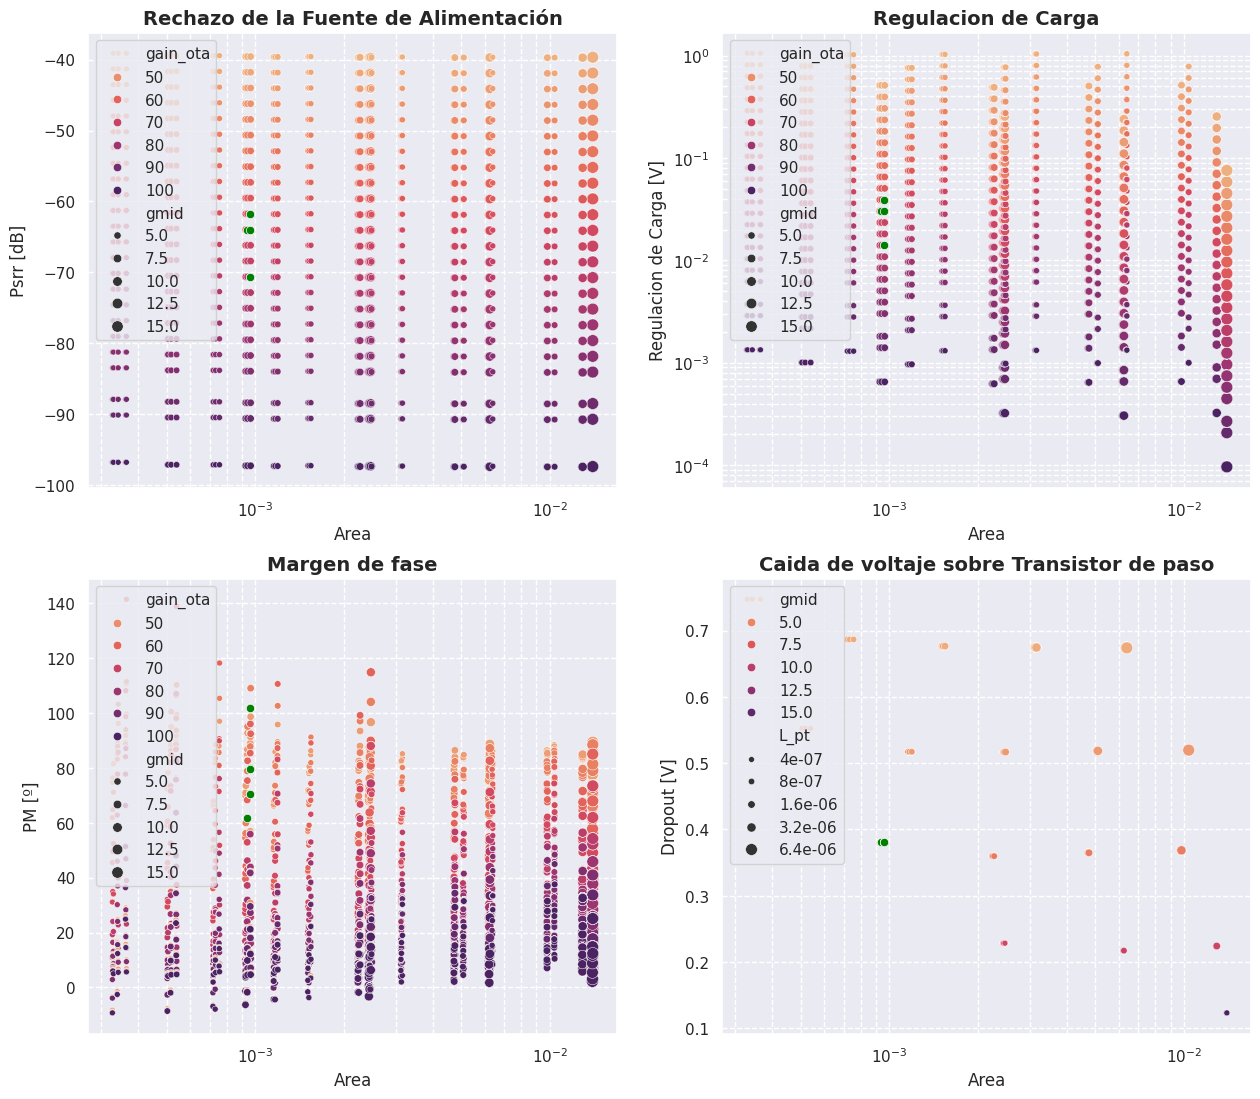

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=ldo_df, x='area', y='psrr', palette='flare', hue='gain_ota', rasterized=True, size='gmid')
sns.scatterplot(ax=axs[0,0], data=ldo_df_new, x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=ldo_df, x='area', y='loadreg', palette='flare', rasterized=True, hue='gain_ota', size='gmid')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new, x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=ldo_df, x='area', y=('dropout'), palette='flare', hue='gmid', rasterized=True, size=('L_pt'))
sns.scatterplot(ax=axs[1,1], data=ldo_df_new, x='area', y=('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=ldo_df, x='area', y="phase_margin_LDO_wc", palette='flare', hue="gain_ota", rasterized=True, size='gmid')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new, x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Area")
axs[0,0].set_ylabel(r"Psrr [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulacion de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Area")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Area")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caida de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Area")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "upper left")
sns.move_legend(axs[0,1], "upper left")
sns.move_legend(axs[1,0], "upper left")
sns.move_legend(axs[1,1], "upper left")

plt.savefig('ldo_explore_raw_gf.pdf')

# OTA 1stage

## Case 2

In [24]:
OTA_1stage_macro.ext_mask = None

OTA_1stage_macro.primitives = [diffpair_wc, activeload_wc, currentsource]
OTA_1stage_macro.submacromodels = [] 
OTA_1stage_macro.num_level_exp = -1
OTA_1stage_macro.specifications = [gain_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_1stage_macro.opt_specifications = [gain_1stage_OTA]
OTA_1stage_macro.is_primitive = 0
OTA_1stage_macro.run_pareto = True

_, _, _, ota_1stage_df_wc, mask = dfs(OTA_1stage_macro, debug = False)

############################################
Starting the exploration of:  OTA_1stage_macro
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 + 2*Raload_1**2*Rcs*gaload_1 + Raload_1**2*Rdiff_1*gaload_1 + Raload_1**2 + 2*Raload_1*Rcs*Rdiff_1**2*gaload_

## Case 1

In [25]:
OTA_1stage_macro.ext_mask = mask

OTA_1stage_macro.primitives = [diffpair, activeload, currentsource]
OTA_1stage_macro.submacromodels = [] 
OTA_1stage_macro.num_level_exp = -1
OTA_1stage_macro.specifications = [gain_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_1stage_macro.opt_specifications = [gain_1stage_OTA]
OTA_1stage_macro.is_primitive = 0
OTA_1stage_macro.run_pareto = True

ota_1stage_results, ota_1stage_axes, ota_1stage_primouts, ota_1stage_df, _ = dfs(OTA_1stage_macro, debug = False)

############################################
Starting the exploration of:  ota_1stage
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 + 2*Raload_1**2*Rcs*gaload_1 + Raload_1**2*Rdiff_1*gaload_1 + Raload_1**2 + 2*Raload_1*Rcs*Rdiff_1**2*gaload_1*gdif

## Filtering

In [26]:
ota_1stage_df_wc["gain"] = 20*np.log10(ota_1stage_df_wc["gain_1stage"])
ota_1stage_df_wc.sort_values(by=Symbol("W_cs"))

gdiff_1       Rdiff_1  vs_diff  gaload_1      Raload_1  vout_aload  \
88004  0.000112  7.409121e+05      0.3  0.000058  2.490405e+07    0.899858   
9504   0.000115  2.093743e+06      0.3  0.000061  6.657411e+06    0.899125   
56754  0.000112  7.409121e+05      0.3  0.000059  1.299140e+07    0.899858   
81629  0.000112  7.408835e+05      0.3  0.000058  2.490867e+07    0.899752   
50379  0.000112  7.408835e+05      0.3  0.000059  1.299357e+07    0.899752   
...         ...           ...      ...       ...           ...         ...   
78395  0.000115  2.094079e+06      0.3  0.000057  2.491817e+07    0.899535   
44020  0.000112  7.408247e+05      0.3  0.000059  1.299805e+07    0.899535   
81645  0.000112  7.408835e+05      0.3  0.000058  2.490867e+07    0.899752   
47145  0.000115  2.094079e+06      0.3  0.000059  1.299805e+07    0.899535   
53520  0.000115  2.094256e+06      0.3  0.000059  1.299357e+07    0.899752   

            gcs           Rcs  vs_cs  vgs_cs  ...  gm_1stage    W_diff  \
88004  0.000073  2.556012e+05    0.3     0.9  ...   0.000110  0.000037   
9504   0.000073  2.556012e+05    0.3     0.9  ...   0.000114  0.000093   
56754  0.000073  2.556012e+05    0.3     0.9  ...   0.000110  0.000037   
81629  0.000073  2.556012e+05    0.3     0.9  ...   0.000110  0.000037   
50379  0.000073  2.556012e+05    0.3     0.9  ...   0.000110  0.000037   
...         ...           ...    ...     ...  ...        ...       ...   
78395  0.000177  3.776144e+06    0.3     0.1  ...   0.000114  0.000093   
44020  0.000177  3.776144e+06    0.3     0.1  ...   0.000110  0.000037   
81645  0.000177  3.776144e+06    0.3     0.1  ...   0.000110  0.000037   
47145  0.000177  3.776144e+06    0.3     0.1  ...   0.000114  0.000093   
53520  0.000177  3.776144e+06    0.3     0.1  ...   0.000114  0.000093   

             L_diff  vout_1stage      W_al          L_al        W_cs  \
88004  4.000000e-07     0.899858  0.000050  3.200000e-06    0.000001   
9504   8.000000e-07     0.899125  0.000012  8.000000e-07    0.000001   
56754  4.000000e-07     0.899858  0.000025  1.600000e-06    0.000001   
81629  4.000000e-07     0.899752  0.000050  3.200000e-06    0.000001   
50379  4.000000e-07     0.899752  0.000025  1.600000e-06    0.000001   
...             ...          ...       ...           ...         ...   
78395  8.000000e-07     0.899535  0.000050  3.200000e-06  233.787522   
44020  4.000000e-07     0.899535  0.000025  1.600000e-06  233.787522   
81645  4.000000e-07     0.899752  0.000050  3.200000e-06  233.787522   
47145  8.000000e-07     0.899535  0.000025  1.600000e-06  233.787522   
53520  8.000000e-07     0.899752  0.000025  1.600000e-06  233.787522   

               L_cs        area       gain  
88004  4.000000e-07    0.000093  38.083728  
9504   4.000000e-07    0.000109  45.221488  
56754  4.000000e-07    0.000066  37.854011  
81629  4.000000e-07    0.000093  38.083470  
50379  4.000000e-07    0.000066  37.853793  
...             ...         ...        ...  
78395  6.400000e-06  233.787676  46.904649  
44020  6.400000e-06  233.787593  37.853252  
81645  6.400000e-06  233.787620  38.083421  
47145  6.400000e-06  233.787649  46.305445  
53520  6.400000e-06  233.787649  46.305651  

[750 rows x 22 columns]

In [27]:
ota_1stage_df["gain"] = 20*np.log10(ota_1stage_df["gain_1stage"])
ota_1stage_df["gain_wc"] = ota_1stage_df_wc["gain"]

ota_1stage_df = ota_1stage_df.dropna()

mask = (ota_1stage_df[Symbol("W_cs")]>5e-6) & (ota_1stage_df[Symbol("W_cs")]<1e-4) & (ota_1stage_df[Symbol("W_al")]<1e-4)
ota_1stage_df_new = ota_1stage_df[mask]


In [28]:
ota_1stage_df_new.to_csv("data/GF_lv_ota_1stage_case1_98_10_10.csv", index=False)

In [29]:
ota_1stage_df_wc = ota_1stage_df_wc[mask]
ota_1stage_df_wc

gdiff_1       Rdiff_1  vs_diff  gaload_1      Raload_1  vout_aload  \
3      0.000112  7.401774e+05      0.3  0.000060  6.676527e+06    0.897146   
8      0.000112  7.401774e+05      0.3  0.000060  6.676527e+06    0.897146   
13     0.000112  7.401774e+05      0.3  0.000060  6.676527e+06    0.897146   
18     0.000112  7.401774e+05      0.3  0.000060  6.676527e+06    0.897146   
19     0.000112  7.401774e+05      0.3  0.000060  6.676527e+06    0.897146   
...         ...           ...      ...       ...           ...         ...   
91133  0.000115  2.094343e+06      0.3  0.000058  2.490405e+07    0.899858   
91138  0.000115  2.094343e+06      0.3  0.000058  2.490405e+07    0.899858   
91143  0.000115  2.094343e+06      0.3  0.000058  2.490405e+07    0.899858   
91144  0.000115  2.094343e+06      0.3  0.000058  2.490405e+07    0.899858   
91149  0.000115  2.094343e+06      0.3  0.000058  2.490405e+07    0.899858   

            gcs           Rcs  vs_cs  vgs_cs  ...  gm_1stage    W_diff  \
3      0.000171  3.578465e+05    0.3     0.7  ...   0.000110  0.000037   
8      0.000179  1.017618e+06    0.3     0.7  ...   0.000110  0.000037   
13     0.000168  1.802622e+06    0.3     0.7  ...   0.000110  0.000037   
18     0.000157  2.876155e+06    0.3     0.7  ...   0.000110  0.000037   
19     0.000072  1.659104e+06    0.3     0.9  ...   0.000110  0.000037   
...         ...           ...    ...     ...  ...        ...       ...   
91133  0.000179  1.017618e+06    0.3     0.7  ...   0.000114  0.000093   
91138  0.000168  1.802622e+06    0.3     0.7  ...   0.000114  0.000093   
91143  0.000157  2.876155e+06    0.3     0.7  ...   0.000114  0.000093   
91144  0.000072  1.659104e+06    0.3     0.9  ...   0.000114  0.000093   
91149  0.000071  2.569981e+06    0.3     0.9  ...   0.000114  0.000093   

             L_diff  vout_1stage      W_al          L_al      W_cs  \
3      4.000000e-07     0.897146  0.000012  8.000000e-07  0.000011   
8      4.000000e-07     0.897146  0.000012  8.000000e-07  0.000024   
13     4.000000e-07     0.897146  0.000012  8.000000e-07  0.000038   
18     4.000000e-07     0.897146  0.000012  8.000000e-07  0.000065   
19     4.000000e-07     0.897146  0.000012  8.000000e-07  0.000007   
...             ...          ...       ...           ...       ...   
91133  8.000000e-07     0.899858  0.000050  3.200000e-06  0.000024   
91138  8.000000e-07     0.899858  0.000050  3.200000e-06  0.000038   
91143  8.000000e-07     0.899858  0.000050  3.200000e-06  0.000065   
91144  8.000000e-07     0.899858  0.000050  3.200000e-06  0.000007   
91149  8.000000e-07     0.899858  0.000050  3.200000e-06  0.000015   

               L_cs      area       gain  
3      4.000000e-07  0.000062  37.409457  
8      8.000000e-07  0.000076  37.409370  
13     1.600000e-06  0.000091  37.409350  
18     3.200000e-06  0.000119  37.409340  
19     3.200000e-06  0.000062  37.409352  
...             ...       ...        ...  
91133  8.000000e-07  0.000173  46.905264  
91138  1.600000e-06  0.000188  46.905258  
91143  3.200000e-06  0.000216  46.905255  
91144  3.200000e-06  0.000158  46.905259  
91149  6.400000e-06  0.000169  46.905256  

[180 rows x 22 columns]

In [30]:
ota_1stage_df_wc.to_csv("data/GF_lv_ota_1stage_case2_98_10_10.csv", index=False)

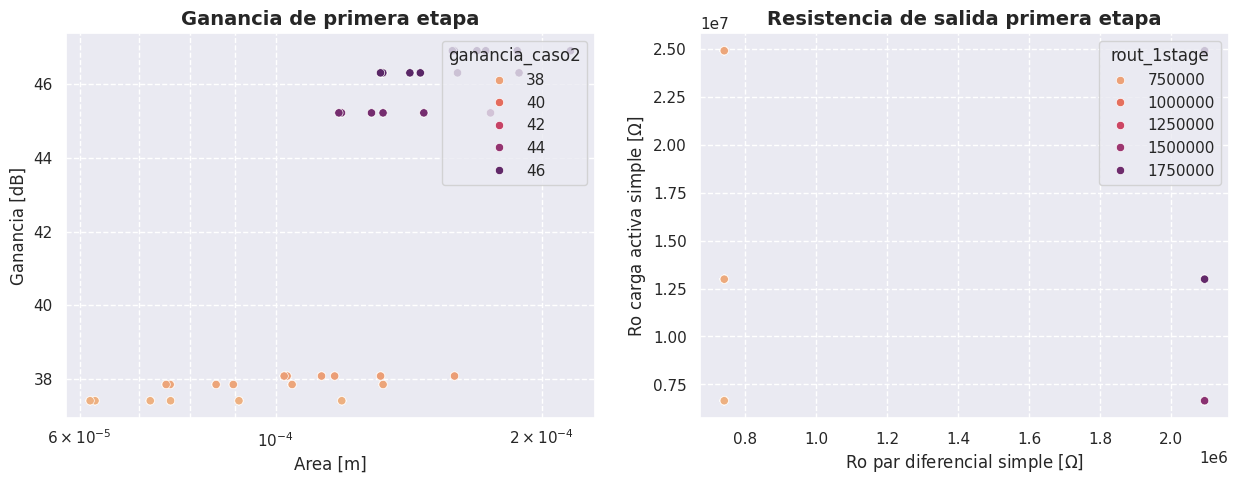

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axs[0], data=ota_1stage_df_new, x="area", y="gain", hue="gain_wc", palette='flare')
sns.scatterplot(ax=axs[1], data=ota_1stage_df_new, x=Symbol("Rdiff_1"), y=Symbol("Raload_1"), hue="rout_1stage", palette='flare')

axs[0].set_title(r"Ganancia de primera etapa", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Resistencia de salida primera etapa", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Ro par diferencial simple $[\Omega]$")
axs[1].set_ylabel(r"Ro carga activa simple $[\Omega]$")
axs[1].legend(loc = 'upper right')

axs[0].set_xscale('log')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  

sns.move_legend(axs[1], "upper right",title="rout_1stage")
sns.move_legend(axs[0], "upper right",title="ganancia_caso2")

plt.savefig('ota_1stage_explore.pdf')

# OTA 2stage 

## Case 2

In [32]:
OTA_2stage_macro.ext_mask = None

OTA_2stage_macro.primitives = [stage2_t_wc, stage2_cs_wc]
OTA_2stage_macro.submacromodels = [] 
OTA_2stage_macro.num_level_exp = -1
OTA_2stage_macro.specifications = [gain_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
OTA_2stage_macro.opt_specifications = [gain_2stage_OTA]
OTA_2stage_macro.is_primitive = 0
OTA_2stage_macro.run_pareto = True

_, _, _, ota_2stage_df_wc, mask = dfs(OTA_2stage_macro, debug = False)

############################################
Starting the exploration of:  OTA_2stage_macro
Netlist:  ota_2stage_v2
Running MNA... 
   vdd  vout  vin  vss
0    1     2    3    0
[('vout', 'vin')]
Netlist:  ota_2stage_rout_v2
Running MNA... 
   vr  vss  vout  vdd  vin
0   1    0     2    3    4
[['vout', 'vr']]
Netlist:  ota_2stage_v2
Running MNA... 
   vdd  vout  vin  vss
0    1     2    3    0
[['vout', 'vin']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Rcs_2stage*Ro_2stage*gm_2stage/(Rcs_2stage + Ro_2stage)
lambdify variables: (gm_2stage, Ro_2stage, Cin_2stage, gcs_2stage, Rcs_2stage, vgs_cs_2stage) <function _lambdifygenerated at 0x7fb26ba7e950>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([8.87998541e-06, 2.43946395e-05, 4.97902512e-05, 1.00706817e-04,
       2.02756861e-04, 2.77293703e-04, 8.58632799e-04, 1.60042738e-03,
       3.07185866e-03, 6.01707760e-03, 3.71089077e-02, 1.20679389e-01,
       2.16046169e-01, 4.04874655

In [33]:
ota_2stage_df_wc["gain"] = 20*np.log10(ota_2stage_df_wc["gain_2stage"])
ota_2stage_df_wc_new = ota_2stage_df_wc[(ota_2stage_df_wc[Symbol("W_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_2stage")]>3e-6) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]>3e-6)]
ota_2stage_df_wc_new.sort_values(by=Symbol("W_2stage"))

gm_2stage      Ro_2stage    Cin_2stage  gcs_2stage    Rcs_2stage  \
69     0.000115  989780.521362  1.266816e-14    0.000166  5.666321e+05   
3056   0.000115  989780.521362  1.266816e-14    0.000035  1.751864e+07   
194    0.000115  989780.521362  1.266816e-14    0.000177  1.702502e+06   
3031   0.000115  989780.521362  1.266816e-14    0.000053  1.483247e+07   
789    0.000115  989780.521362  1.266816e-14    0.000218  1.255514e+06   
...         ...            ...           ...         ...           ...   
574    0.000220  695925.599852  3.451801e-13    0.000150  6.117188e+06   
74     0.000220  695925.599852  3.451801e-13    0.000166  5.666321e+05   
599    0.000220  695925.599852  3.451801e-13    0.000071  1.236960e+07   
3036   0.000220  695925.599852  3.451801e-13    0.000053  1.483247e+07   
3061   0.000220  695925.599852  3.451801e-13    0.000035  1.751864e+07   

      vgs_cs_2stage  gain_2stage    rout_2stage  gm_2stage  W_2stage  \
69            0.700    41.415668  360342.389591   0.000115  0.000009   
3056          1.200   107.676084  936849.717160   0.000115  0.000009   
194           0.700    71.937483  625901.390907   0.000115  0.000009   
3031          1.000   106.643268  927863.570683   0.000115  0.000009   
789           0.625    63.611620  553461.145518   0.000115  0.000009   
...             ...          ...            ...        ...       ...   
574           0.700   137.359246  624840.271113   0.000220  0.000277   
74            0.700    68.659661  312329.330441   0.000220  0.000277   
599           0.900   144.837315  658857.625950   0.000220  0.000277   
3036          1.000   146.129733  664736.772272   0.000220  0.000277   
3061          1.200   147.140853  669336.302994   0.000220  0.000277   

          L_2stage  vin_2stage  W_cs_2stage   L_cs_2stage      area       gain  
69    4.000000e-07    0.897146     0.000011  4.000000e-07  0.000021  32.343294  
3056  4.000000e-07    0.897146     0.000003  6.400000e-06  0.000019  40.642385  
194   4.000000e-07    0.897146     0.000024  8.000000e-07  0.000034  37.139105  
3031  4.000000e-07    0.897146     0.000008  6.400000e-06  0.000024  40.558669  
789   4.000000e-07    0.897146     0.000108  8.000000e-07  0.000118  36.070729  
...            ...         ...          ...           ...       ...        ...  
574   4.000000e-07    1.097781     0.000120  6.400000e-06  0.000404  42.757158  
74    4.000000e-07    1.097781     0.000011  4.000000e-07  0.000289  36.734033  
599   4.000000e-07    1.097781     0.000015  6.400000e-06  0.000299  43.217609  
3036  4.000000e-07    1.097781     0.000008  6.400000e-06  0.000292  43.294772  
3061  4.000000e-07    1.097781     0.000003  6.400000e-06  0.000287  43.354665  

[276 rows x 16 columns]

## Case 1

In [34]:
OTA_2stage_macro.ext_mask = mask

OTA_2stage_macro.primitives = [stage2_t, stage2_cs]
OTA_2stage_macro.submacromodels = [] 
OTA_2stage_macro.num_level_exp = -1
OTA_2stage_macro.specifications = [gain_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
OTA_2stage_macro.opt_specifications = [gain_2stage_OTA]
OTA_2stage_macro.is_primitive = 0
OTA_2stage_macro.run_pareto = True

_, _, _, ota_2stage_df, _ = dfs(OTA_2stage_macro, debug = False)

############################################
Starting the exploration of:  ota_2stage_v2
Netlist:  ota_2stage_v2
Running MNA... 
   vdd  vout  vin  vss
0    1     2    3    0
[('vout', 'vin')]
Netlist:  ota_2stage_rout_v2
Running MNA... 
   vr  vss  vout  vdd  vin
0   1    0     2    3    4
[['vout', 'vr']]
Netlist:  ota_2stage_v2
Running MNA... 
   vdd  vout  vin  vss
0    1     2    3    0
[['vout', 'vin']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Rcs_2stage*Ro_2stage*gm_2stage/(Rcs_2stage + Ro_2stage)
lambdify variables: (gm_2stage, Ro_2stage, Cin_2stage, gcs_2stage, Rcs_2stage, vgs_cs_2stage) <function _lambdifygenerated at 0x7fb26baabd00>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([8.87998541e-06, 2.43946395e-05, 4.97902512e-05, 1.00706817e-04,
       2.02756861e-04, 2.77293703e-04, 8.58632799e-04, 1.60042738e-03,
       3.07185866e-03, 6.01707760e-03, 3.71089077e-02, 1.20679389e-01,
       2.16046169e-01, 4.04874655e-0

In [35]:
ota_2stage_df["gain"] = 20*np.log10(ota_2stage_df["gain_2stage"])
ota_2stage_df_new = ota_2stage_df[(ota_2stage_df_wc[Symbol("W_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_2stage")]>3e-6) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]>3e-6)]
ota_2stage_df_new

gm_2stage     Ro_2stage    Cin_2stage  gcs_2stage    Rcs_2stage  \
69     0.000116  1.190937e+06  1.346076e-14    0.000169  5.141932e+05   
70     0.000122  3.843924e+06  6.353348e-14    0.000169  5.141932e+05   
71     0.000118  7.495042e+06  2.629607e-13    0.000169  5.141932e+05   
72     0.000115  1.441165e+07  1.048031e-12    0.000169  5.141932e+05   
73     0.000114  2.553875e+07  4.279453e-12    0.000169  5.141932e+05   
...         ...           ...           ...         ...           ...   
3057   0.000122  3.843924e+06  6.353348e-14    0.000035  1.006658e+07   
3058   0.000118  7.495042e+06  2.629607e-13    0.000035  1.006658e+07   
3059   0.000115  1.441165e+07  1.048031e-12    0.000035  1.006658e+07   
3060   0.000114  2.553875e+07  4.279453e-12    0.000035  1.006658e+07   
3061   0.000220  7.758684e+05  3.547102e-13    0.000035  1.006658e+07   

      vgs_cs_2stage  gain_2stage   rout_2stage  gm_2stage  W_2stage  \
69              0.7    41.585885  3.591349e+05   0.000116  0.000009   
70              0.7    55.381381  4.535261e+05   0.000122  0.000024   
71              0.7    56.624906  4.811820e+05   0.000118  0.000050   
72              0.7    57.188572  4.964794e+05   0.000115  0.000101   
73              0.7    57.417789  5.040449e+05   0.000114  0.000203   
...             ...          ...           ...        ...       ...   
3057            1.2   339.684252  2.781723e+06   0.000122  0.000024   
3058            1.2   505.579613  4.296269e+06   0.000118  0.000050   
3059            1.2   682.690449  5.926739e+06   0.000115  0.000101   
3060            1.2   822.515139  7.220490e+06   0.000114  0.000203   
3061            1.2   158.404508  7.203485e+05   0.000220  0.000277   

          L_2stage  vin_2stage  W_cs_2stage   L_cs_2stage      area       gain  
69    4.000000e-07         0.9     0.000011  4.000000e-07  0.000021  32.378919  
70    8.000000e-07         0.9     0.000011  4.000000e-07  0.000037  34.867276  
71    1.600000e-06         0.9     0.000011  4.000000e-07  0.000063  35.060150  
72    3.200000e-06         0.9     0.000011  4.000000e-07  0.000115  35.146185  
73    6.400000e-06         0.9     0.000011  4.000000e-07  0.000221  35.180929  
...            ...         ...          ...           ...       ...        ...  
3057  8.000000e-07         0.9     0.000003  6.400000e-06  0.000035  50.621508  
3058  1.600000e-06         0.9     0.000003  6.400000e-06  0.000061  54.075791  
3059  3.200000e-06         0.9     0.000003  6.400000e-06  0.000114  56.684477  
3060  6.400000e-06         0.9     0.000003  6.400000e-06  0.000219  58.302878  
3061  4.000000e-07         1.1     0.000003  6.400000e-06  0.000287  43.995351  

[276 rows x 16 columns]

## filtering

In [36]:
mask = (ota_2stage_df["gain"]>15) & (ota_2stage_df[Symbol("W_2stage")]<1e-4) & (ota_2stage_df[Symbol("W_cs_2stage")]>5e-6) & (ota_2stage_df[Symbol("W_cs_2stage")]<1e-4)
ota_2stage_df_new = ota_2stage_df_new[mask]
ota_2stage_df_wc_new = ota_2stage_df_wc_new[mask]

/tmp/ipykernel_49141/533869183.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ota_2stage_df_new = ota_2stage_df_new[mask]
/tmp/ipykernel_49141/533869183.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ota_2stage_df_wc_new = ota_2stage_df_wc_new[mask]


In [37]:
ota_2stage_df_new["gain_wc"] = ota_2stage_df_wc_new["gain"]
ota_2stage_df_new

/tmp/ipykernel_49141/3031976428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ota_2stage_df_new["gain_wc"] = ota_2stage_df_wc_new["gain"]


gm_2stage     Ro_2stage    Cin_2stage  gcs_2stage    Rcs_2stage  \
69     0.000116  1.190937e+06  1.346076e-14    0.000169  5.141932e+05   
70     0.000122  3.843924e+06  6.353348e-14    0.000169  5.141932e+05   
71     0.000118  7.495042e+06  2.629607e-13    0.000169  5.141932e+05   
194    0.000116  1.190937e+06  1.346076e-14    0.000178  1.533581e+06   
195    0.000122  3.843924e+06  6.353348e-14    0.000178  1.533581e+06   
...         ...           ...           ...         ...           ...   
3007   0.000122  3.843924e+06  6.353348e-14    0.000101  8.372509e+06   
3008   0.000118  7.495042e+06  2.629607e-13    0.000101  8.372509e+06   
3031   0.000116  1.190937e+06  1.346076e-14    0.000053  1.148210e+07   
3032   0.000122  3.843924e+06  6.353348e-14    0.000053  1.148210e+07   
3033   0.000118  7.495042e+06  2.629607e-13    0.000053  1.148210e+07   

      vgs_cs_2stage  gain_2stage   rout_2stage  gm_2stage  W_2stage  \
69              0.7    41.585885  3.591349e+05   0.000116  0.000009   
70              0.7    55.381381  4.535261e+05   0.000122  0.000024   
71              0.7    56.624906  4.811820e+05   0.000118  0.000050   
194             0.7    77.623670  6.703565e+05   0.000116  0.000009   
195             0.7   133.863498  1.096227e+06   0.000122  0.000024   
...             ...          ...           ...        ...       ...   
3007            0.8   321.697357  2.634426e+06   0.000122  0.000024   
3008            0.8   465.390895  3.954757e+06   0.000118  0.000050   
3031            1.0   124.944696  1.079020e+06   0.000116  0.000009   
3032            1.0   351.664185  2.879828e+06   0.000122  0.000024   
3033            1.0   533.657640  4.534868e+06   0.000118  0.000050   

          L_2stage  vin_2stage  W_cs_2stage   L_cs_2stage      area  \
69    4.000000e-07         0.9     0.000011  4.000000e-07  0.000021   
70    8.000000e-07         0.9     0.000011  4.000000e-07  0.000037   
71    1.600000e-06         0.9     0.000011  4.000000e-07  0.000063   
194   4.000000e-07         0.9     0.000024  8.000000e-07  0.000034   
195   8.000000e-07         0.9     0.000024  8.000000e-07  0.000050   
...            ...         ...          ...           ...       ...   
3007  8.000000e-07         0.9     0.000034  6.400000e-06  0.000066   
3008  1.600000e-06         0.9     0.000034  6.400000e-06  0.000092   
3031  4.000000e-07         0.9     0.000008  6.400000e-06  0.000024   
3032  8.000000e-07         0.9     0.000008  6.400000e-06  0.000040   
3033  1.600000e-06         0.9     0.000008  6.400000e-06  0.000066   

           gain    gain_wc  
69    32.378919  32.343294  
70    34.867276  35.231915  
71    35.060150  35.640386  
194   37.799883  37.139105  
195   42.533243  42.336669  
...         ...        ...  
3007  50.148950  48.640722  
3008  53.356358  52.353553  
3031  41.934356  40.558669  
3032  50.922563  49.448020  
3033  54.545255  53.673680  

[90 rows x 17 columns]

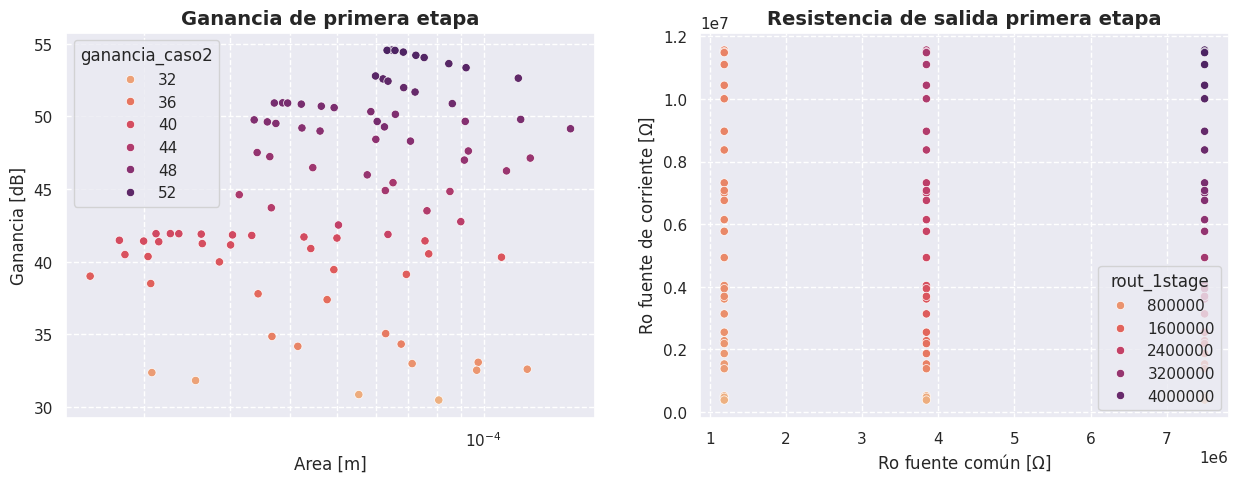

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axs[0], data=ota_2stage_df_new, x="area", y="gain", palette='flare', hue="gain_wc")
sns.scatterplot(ax=axs[1], data=ota_2stage_df_new, x=Symbol("Ro_2stage"), y=Symbol("Rcs_2stage"), hue="rout_2stage", palette='flare')

axs[0].set_title(r"Ganancia de primera etapa", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Resistencia de salida primera etapa", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Ro fuente común $[\Omega]$")
axs[1].set_ylabel(r"Ro fuente de corriente $[\Omega]$")
axs[1].legend(loc = 'upper right')

axs[0].set_xscale('log')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  

sns.move_legend(axs[1], "lower right",title="rout_1stage")
sns.move_legend(axs[0], "upper left",title="ganancia_caso2")

plt.savefig('ota_2stage_explore.pdf')

In [40]:
ota_2stage_df_new.to_csv("data/GF_lv_ota_2stage_case1.csv", index=False)
ota_2stage_df_wc_new.to_csv("data/GF_lv_ota_2stage_case2.csv", index=False)

# OTA exploration 3

In [59]:
ota_1stage_df_new = pd.read_csv("data/GF_lv_ota_1stage_case1_98_10_10.csv")
#ota_1stage_df_new = ota_1stage_df_new.sort_values(by="gain").drop_duplicates()
print(len(ota_1stage_df_new))

ota_2stage_df_new = pd.read_csv("data/GF_lv_ota_2stage_case1.csv")
#mask = (ota_2stage_df_new["Ro_2stage"]>10000) & (ota_2stage_df_new["Ro_2stage"]<1000000)
#ota_2stage_df_new = ota_2stage_df_new[mask]
print(len(ota_2stage_df_new))

180
90


In [60]:
ota_1stage_df_wc_new = pd.read_csv("data/GF_lv_ota_1stage_case2_98_10_10.csv")
print(len(ota_1stage_df_wc_new))

ota_2stage_df_wc_new = pd.read_csv("data/GF_lv_ota_2stage_case2.csv")
#ota_2stage_df_wc_new = ota_2stage_df_wc_new[mask]
print(len(ota_2stage_df_wc_new))

180
90


In [61]:
OTA_2stage_primitive_wc = Primitive(parameters={Symbol("Ra_2stage"): ota_2stage_df_wc_new["rout_2stage"].values,
                                  Symbol("gma_2stage"): ota_2stage_df_wc_new["gm_2stage"].values,
                                  Symbol("Cin_2stage"): ota_2stage_df_wc_new["Cin_2stage"].values})

OTA_2stage_primitive_wc.outputs = {
    Symbol("W_2stage"): ota_2stage_df_wc_new["W_2stage"].values,
    Symbol("L_2stage"): ota_2stage_df_wc_new["L_2stage"].values,
    Symbol("vin_2stage"): ota_2stage_df_wc_new["vin_2stage"].values,
    Symbol("W_cs_2stage"): ota_2stage_df_wc_new["W_cs_2stage"].values,
    Symbol("L_cs_2stage"): ota_2stage_df_wc_new["L_cs_2stage"].values,
    Symbol("vgs_cs_2stage"): ota_2stage_df_wc_new["vgs_cs_2stage"].values}

OTA_1stage_primitive_wc = Primitive(parameters={
    Symbol("Ra_1stage"): ota_1stage_df_wc_new["rout_1stage"].values,
    Symbol("gma_1stage"): ota_1stage_df_wc_new["gm_1stage"].values})
OTA_1stage_primitive_wc.outputs = {
    Symbol("W_diff"): ota_1stage_df_wc_new["W_diff"].values,
    Symbol("L_diff"): ota_1stage_df_wc_new["L_diff"].values,
    Symbol("vout_1stage"): ota_1stage_df_wc_new["vout_1stage"].values,
    Symbol("W_al"): ota_1stage_df_wc_new["W_al"].values,
    Symbol("L_al"): ota_1stage_df_wc_new["L_al"].values,
    Symbol("W_cs"): ota_1stage_df_wc_new["W_cs"].values,
    Symbol("L_cs"): ota_1stage_df_wc_new["L_cs"].values,
    Symbol("vgs_cs"): ota_1stage_df_wc_new["vgs_cs"].values}

In [62]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt_wc}

rout_OTA.parametros = {
    Symbol("Vpos"): 0,
    Symbol("Vr"): 1,
    Symbol("s"): 0,
    Symbol("Rr"): 1000,
    Symbol("Cin_pt"): Cin_pt_wc}

OTA_macro.ext_mask = None

OTA_macro.primitives = [OTA_2stage_primitive_wc, OTA_1stage_primitive_wc, Cc_primitive]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, mask_ota = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7fb26b54d750>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([8.87998541e-06, 2.43946395e-05, 4.97902512e-05, 8.87998541e-06,
       2.43946395e-05, 4.97902512e-05, 8.87998541e-06, 2.43946395e-05,
       4.97902512e-05, 8.87998541e-06, 2.43946395e-05, 4.97902512e-05,
       8.87

In [63]:
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])
ota_df_wc

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
0       3.603424e+05    0.000115  1.266816e-14  6.736577e+05    0.000110   
1       3.603424e+05    0.000115  1.266816e-14  6.736577e+05    0.000110   
2       3.603424e+05    0.000115  1.266816e-14  6.736577e+05    0.000110   
3       3.603424e+05    0.000115  1.266816e-14  6.736577e+05    0.000110   
4       3.603424e+05    0.000115  1.266816e-14  6.736577e+05    0.000110   
...              ...         ...           ...           ...         ...   
125707  3.893778e+06    0.000117  2.970896e-13  1.939743e+06    0.000114   
125708  3.893778e+06    0.000117  2.970896e-13  1.939743e+06    0.000114   
125709  3.893778e+06    0.000117  2.970896e-13  1.939743e+06    0.000114   
125710  3.893778e+06    0.000117  2.970896e-13  1.939743e+06    0.000114   
125711  3.893778e+06    0.000117  2.970896e-13  1.939743e+06    0.000114   

                  Cc        Rc       gain_OTA      rout_OTA    gm_OTA  ...  \
0       1.000000e-13    1000.0    3073.530594  3.603424e+05  0.008529  ...   
1       3.162278e-12    1000.0    3073.530594  3.603424e+05  0.008529  ...   
2       1.000000e-10    1000.0    3073.530594  3.603424e+05  0.008529  ...   
3       1.000000e-13   10000.0    3073.530594  3.603424e+05  0.008529  ...   
4       3.162278e-12   10000.0    3073.530594  3.603424e+05  0.008529  ...   
...              ...       ...            ...           ...       ...  ...   
125707  3.162278e-12   10000.0  101298.174301  3.893778e+06  0.026015  ...   
125708  1.000000e-10   10000.0  101298.174301  3.893778e+06  0.026015  ...   
125709  1.000000e-13  100000.0  101298.174301  3.893778e+06  0.026015  ...   
125710  3.162278e-12  100000.0  101298.174301  3.893778e+06  0.026015  ...   
125711  1.000000e-10  100000.0  101298.174301  3.893778e+06  0.026015  ...   

                L_al      W_cs          L_cs  vgs_cs      W_cc      L_cc  \
0       8.000000e-07  0.000011  4.000000e-07     0.7  0.000008  0.000008   
1       8.000000e-07  0.000011  4.000000e-07     0.7  0.000046  0.000046   
2       8.000000e-07  0.000011  4.000000e-07     0.7  0.000258  0.000258   
3       8.000000e-07  0.000011  4.000000e-07     0.7  0.000008  0.000008   
4       8.000000e-07  0.000011  4.000000e-07     0.7  0.000046  0.000046   
...              ...       ...           ...     ...       ...       ...   
125707  3.200000e-06  0.000015  6.400000e-06     0.9  0.000046  0.000046   
125708  3.200000e-06  0.000015  6.400000e-06     0.9  0.000258  0.000258   
125709  3.200000e-06  0.000015  6.400000e-06     0.9  0.000008  0.000008   
125710  3.200000e-06  0.000015  6.400000e-06     0.9  0.000046  0.000046   
125711  3.200000e-06  0.000015  6.400000e-06     0.9  0.000258  0.000258   

            W_rc          L_rc      area        gain  
0       0.000001  5.000000e-07  0.000101   69.752751  
1       0.000001  5.000000e-07  0.000177   69.752751  
2       0.000001  5.000000e-07  0.000601   69.752751  
3       0.000004  5.000000e-07  0.000104   69.752751  
4       0.000004  5.000000e-07  0.000179   69.752751  
...          ...           ...       ...         ...  
125707  0.000004  5.000000e-07  0.000338  100.112032  
125708  0.000004  5.000000e-07  0.000762  100.112032  
125709  0.000012  5.000000e-07  0.000270  100.112032  
125710  0.000012  5.000000e-07  0.000346  100.112032  
125711  0.000012  5.000000e-07  0.000770  100.112032  

[972 rows x 30 columns]

In [64]:
OTA_2stage_primitive = Primitive(parameters={Symbol("Ra_2stage"): ota_2stage_df_new["rout_2stage"].values,
                                  Symbol("gma_2stage"): ota_2stage_df_new["gm_2stage"].values,
                                  Symbol("Cin_2stage"): ota_2stage_df_new["Cin_2stage"].values})

OTA_2stage_primitive.outputs = {
    Symbol("W_2stage"): ota_2stage_df_new["W_2stage"].values,
    Symbol("L_2stage"): ota_2stage_df_new["L_2stage"].values,
    Symbol("vin_2stage"): ota_2stage_df_new["vin_2stage"].values,
    Symbol("W_cs_2stage"): ota_2stage_df_new["W_cs_2stage"].values,
    Symbol("L_cs_2stage"): ota_2stage_df_new["L_cs_2stage"].values,
    Symbol("vgs_cs_2stage"): ota_2stage_df_new["vgs_cs_2stage"].values}

OTA_1stage_primitive = Primitive(parameters={
    Symbol("Ra_1stage"): ota_1stage_df_new["rout_1stage"].values,
    Symbol("gma_1stage"): ota_1stage_df_new["gm_1stage"].values})
OTA_1stage_primitive.outputs = {
    Symbol("W_diff"): ota_1stage_df_new["W_diff"].values,
    Symbol("L_diff"): ota_1stage_df_new["L_diff"].values,
    Symbol("vout_1stage"): ota_1stage_df_new["vout_1stage"].values,
    Symbol("W_al"): ota_1stage_df_new["W_al"].values,
    Symbol("L_al"): ota_1stage_df_new["L_al"].values,
    Symbol("W_cs"): ota_1stage_df_new["W_cs"].values,
    Symbol("L_cs"): ota_1stage_df_new["L_cs"].values,
    Symbol("vgs_cs"): ota_1stage_df_new["vgs_cs"].values}

In [65]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt}

rout_OTA.parametros = {
    Symbol("Vpos"): 0,
    Symbol("Vr"): 1,
    Symbol("s"): 0,
    Symbol("Rr"): 1000,
    Symbol("Cin_pt"): Cin_pt}

OTA_macro.ext_mask = mask_ota

OTA_macro.primitives = [OTA_2stage_primitive, OTA_1stage_primitive, Cc_primitive]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 


   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7fb26b8d9e10>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([8.87998541e-06, 2.43946395e-05, 4.97902512e-05, 8.87998541e-06,
       2.43946395e-05, 4.97902512e-05, 8.87998541e-06, 2.43946395e-05,
       4.97902512e-05, 8.87998541e-06, 2.43946395e-05, 4.97902512e-05,
       8.87998541e-06, 2.43946395e-05, 4.97902512e-05, 8.87998541e-06,
       2.43946395e-05, 4.97902512e-05, 8.87998541e-06, 2.43946395e-05,
       4.97902512e-05, 8.87998541e-06, 2.43946395e-05, 4.97902512e-05,
       8.87998541e-06, 2.43946395e-05, 4.97902512e

In [66]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
0       3.591349e+05    0.000116  1.346076e-14  6.739142e+05    0.000110   
1       3.591349e+05    0.000116  1.346076e-14  6.739142e+05    0.000110   
2       3.591349e+05    0.000116  1.346076e-14  6.739142e+05    0.000110   
3       3.591349e+05    0.000116  1.346076e-14  6.739142e+05    0.000110   
4       3.591349e+05    0.000116  1.346076e-14  6.739142e+05    0.000110   
...              ...         ...           ...           ...         ...   
145147  4.362665e+06    0.000118  2.629607e-13  1.939928e+06    0.000114   
145148  4.362665e+06    0.000118  2.629607e-13  1.939928e+06    0.000114   
145149  4.362665e+06    0.000118  2.629607e-13  1.939928e+06    0.000114   
145150  4.362665e+06    0.000118  2.629607e-13  1.939928e+06    0.000114   
145151  4.362665e+06    0.000118  2.629607e-13  1.939928e+06    0.000114   

                  Cc        Rc       gain_OTA      rout_OTA    gm_OTA  ...  \
0       1.000000e-13    1000.0    3087.604351  3.591349e+05  0.008597  ...   
1       3.162278e-12    1000.0    3087.604351  3.591349e+05  0.008597  ...   
2       1.000000e-10    1000.0    3087.604351  3.591349e+05  0.008597  ...   
3       1.000000e-13   10000.0    3087.604351  3.591349e+05  0.008597  ...   
4       3.162278e-12   10000.0    3087.604351  3.591349e+05  0.008597  ...   
...              ...       ...            ...           ...       ...  ...   
145147  3.162278e-12   10000.0  113691.020349  4.362665e+06  0.026060  ...   
145148  1.000000e-10   10000.0  113691.020349  4.362665e+06  0.026060  ...   
145149  1.000000e-13  100000.0  113691.020349  4.362665e+06  0.026060  ...   
145150  3.162278e-12  100000.0  113691.020349  4.362665e+06  0.026060  ...   
145151  1.000000e-10  100000.0  113691.020349  4.362665e+06  0.026060  ...   

                L_al      W_cs          L_cs  vgs_cs      W_cc      L_cc  \
0       8.000000e-07  0.000011  4.000000e-07     0.7  0.000008  0.000008   
1       8.000000e-07  0.000011  4.000000e-07     0.7  0.000046  0.000046   
2       8.000000e-07  0.000011  4.000000e-07     0.7  0.000258  0.000258   
3       8.000000e-07  0.000011  4.000000e-07     0.7  0.000008  0.000008   
4       8.000000e-07  0.000011  4.000000e-07     0.7  0.000046  0.000046   
...              ...       ...           ...     ...       ...       ...   
145147  3.200000e-06  0.000015  6.400000e-06     0.9  0.000046  0.000046   
145148  3.200000e-06  0.000015  6.400000e-06     0.9  0.000258  0.000258   
145149  3.200000e-06  0.000015  6.400000e-06     0.9  0.000008  0.000008   
145150  3.200000e-06  0.000015  6.400000e-06     0.9  0.000046  0.000046   
145151  3.200000e-06  0.000015  6.400000e-06     0.9  0.000258  0.000258   

            W_rc          L_rc      area        gain  
0       0.000001  5.000000e-07  0.000101   69.792433  
1       0.000001  5.000000e-07  0.000177   69.792433  
2       0.000001  5.000000e-07  0.000601   69.792433  
3       0.000004  5.000000e-07  0.000104   69.792433  
4       0.000004  5.000000e-07  0.000179   69.792433  
...          ...           ...       ...         ...  
145147  0.000004  5.000000e-07  0.000338  101.114523  
145148  0.000004  5.000000e-07  0.000762  101.114523  
145149  0.000012  5.000000e-07  0.000270  101.114523  
145150  0.000012  5.000000e-07  0.000346  101.114523  
145151  0.000012  5.000000e-07  0.000770  101.114523  

[4860 rows x 30 columns]

In [67]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])
ota_df = ota_df.dropna()
ota_df

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
0       3.591349e+05    0.000116  1.346076e-14  6.739142e+05    0.000110   
1       3.591349e+05    0.000116  1.346076e-14  6.739142e+05    0.000110   
2       3.591349e+05    0.000116  1.346076e-14  6.739142e+05    0.000110   
3       3.591349e+05    0.000116  1.346076e-14  6.739142e+05    0.000110   
4       3.591349e+05    0.000116  1.346076e-14  6.739142e+05    0.000110   
...              ...         ...           ...           ...         ...   
125707  4.362665e+06    0.000118  2.629607e-13  1.939928e+06    0.000114   
125708  4.362665e+06    0.000118  2.629607e-13  1.939928e+06    0.000114   
125709  4.362665e+06    0.000118  2.629607e-13  1.939928e+06    0.000114   
125710  4.362665e+06    0.000118  2.629607e-13  1.939928e+06    0.000114   
125711  4.362665e+06    0.000118  2.629607e-13  1.939928e+06    0.000114   

                  Cc        Rc       gain_OTA      rout_OTA    gm_OTA  ...  \
0       1.000000e-13    1000.0    3087.604351  3.591349e+05  0.008597  ...   
1       3.162278e-12    1000.0    3087.604351  3.591349e+05  0.008597  ...   
2       1.000000e-10    1000.0    3087.604351  3.591349e+05  0.008597  ...   
3       1.000000e-13   10000.0    3087.604351  3.591349e+05  0.008597  ...   
4       3.162278e-12   10000.0    3087.604351  3.591349e+05  0.008597  ...   
...              ...       ...            ...           ...       ...  ...   
125707  3.162278e-12   10000.0  113691.020349  4.362665e+06  0.026060  ...   
125708  1.000000e-10   10000.0  113691.020349  4.362665e+06  0.026060  ...   
125709  1.000000e-13  100000.0  113691.020349  4.362665e+06  0.026060  ...   
125710  3.162278e-12  100000.0  113691.020349  4.362665e+06  0.026060  ...   
125711  1.000000e-10  100000.0  113691.020349  4.362665e+06  0.026060  ...   

            W_cs          L_cs  vgs_cs      W_cc      L_cc      W_rc  \
0       0.000011  4.000000e-07     0.7  0.000008  0.000008  0.000001   
1       0.000011  4.000000e-07     0.7  0.000046  0.000046  0.000001   
2       0.000011  4.000000e-07     0.7  0.000258  0.000258  0.000001   
3       0.000011  4.000000e-07     0.7  0.000008  0.000008  0.000004   
4       0.000011  4.000000e-07     0.7  0.000046  0.000046  0.000004   
...          ...           ...     ...       ...       ...       ...   
125707  0.000015  6.400000e-06     0.9  0.000046  0.000046  0.000004   
125708  0.000015  6.400000e-06     0.9  0.000258  0.000258  0.000004   
125709  0.000015  6.400000e-06     0.9  0.000008  0.000008  0.000012   
125710  0.000015  6.400000e-06     0.9  0.000046  0.000046  0.000012   
125711  0.000015  6.400000e-06     0.9  0.000258  0.000258  0.000012   

                L_rc      area        gain     gain_wc  
0       5.000000e-07  0.000101   69.792433   69.752751  
1       5.000000e-07  0.000177   69.792433   69.752751  
2       5.000000e-07  0.000601   69.792433   69.752751  
3       5.000000e-07  0.000104   69.792433   69.752751  
4       5.000000e-07  0.000179   69.792433   69.752751  
...              ...       ...         ...         ...  
125707  5.000000e-07  0.000338  101.114523  100.112032  
125708  5.000000e-07  0.000762  101.114523  100.112032  
125709  5.000000e-07  0.000270  101.114523  100.112032  
125710  5.000000e-07  0.000346  101.114523  100.112032  
125711  5.000000e-07  0.000770  101.114523  100.112032  

[972 rows x 31 columns]

In [68]:
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])
ota_df_wc

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
0       3.603424e+05    0.000115  1.266816e-14  6.736577e+05    0.000110   
1       3.603424e+05    0.000115  1.266816e-14  6.736577e+05    0.000110   
2       3.603424e+05    0.000115  1.266816e-14  6.736577e+05    0.000110   
3       3.603424e+05    0.000115  1.266816e-14  6.736577e+05    0.000110   
4       3.603424e+05    0.000115  1.266816e-14  6.736577e+05    0.000110   
...              ...         ...           ...           ...         ...   
125707  3.893778e+06    0.000117  2.970896e-13  1.939743e+06    0.000114   
125708  3.893778e+06    0.000117  2.970896e-13  1.939743e+06    0.000114   
125709  3.893778e+06    0.000117  2.970896e-13  1.939743e+06    0.000114   
125710  3.893778e+06    0.000117  2.970896e-13  1.939743e+06    0.000114   
125711  3.893778e+06    0.000117  2.970896e-13  1.939743e+06    0.000114   

                  Cc        Rc       gain_OTA      rout_OTA    gm_OTA  ...  \
0       1.000000e-13    1000.0    3073.530594  3.603424e+05  0.008529  ...   
1       3.162278e-12    1000.0    3073.530594  3.603424e+05  0.008529  ...   
2       1.000000e-10    1000.0    3073.530594  3.603424e+05  0.008529  ...   
3       1.000000e-13   10000.0    3073.530594  3.603424e+05  0.008529  ...   
4       3.162278e-12   10000.0    3073.530594  3.603424e+05  0.008529  ...   
...              ...       ...            ...           ...       ...  ...   
125707  3.162278e-12   10000.0  101298.174301  3.893778e+06  0.026015  ...   
125708  1.000000e-10   10000.0  101298.174301  3.893778e+06  0.026015  ...   
125709  1.000000e-13  100000.0  101298.174301  3.893778e+06  0.026015  ...   
125710  3.162278e-12  100000.0  101298.174301  3.893778e+06  0.026015  ...   
125711  1.000000e-10  100000.0  101298.174301  3.893778e+06  0.026015  ...   

                L_al      W_cs          L_cs  vgs_cs      W_cc      L_cc  \
0       8.000000e-07  0.000011  4.000000e-07     0.7  0.000008  0.000008   
1       8.000000e-07  0.000011  4.000000e-07     0.7  0.000046  0.000046   
2       8.000000e-07  0.000011  4.000000e-07     0.7  0.000258  0.000258   
3       8.000000e-07  0.000011  4.000000e-07     0.7  0.000008  0.000008   
4       8.000000e-07  0.000011  4.000000e-07     0.7  0.000046  0.000046   
...              ...       ...           ...     ...       ...       ...   
125707  3.200000e-06  0.000015  6.400000e-06     0.9  0.000046  0.000046   
125708  3.200000e-06  0.000015  6.400000e-06     0.9  0.000258  0.000258   
125709  3.200000e-06  0.000015  6.400000e-06     0.9  0.000008  0.000008   
125710  3.200000e-06  0.000015  6.400000e-06     0.9  0.000046  0.000046   
125711  3.200000e-06  0.000015  6.400000e-06     0.9  0.000258  0.000258   

            W_rc          L_rc      area        gain  
0       0.000001  5.000000e-07  0.000101   69.752751  
1       0.000001  5.000000e-07  0.000177   69.752751  
2       0.000001  5.000000e-07  0.000601   69.752751  
3       0.000004  5.000000e-07  0.000104   69.752751  
4       0.000004  5.000000e-07  0.000179   69.752751  
...          ...           ...       ...         ...  
125707  0.000004  5.000000e-07  0.000338  100.112032  
125708  0.000004  5.000000e-07  0.000762  100.112032  
125709  0.000012  5.000000e-07  0.000270  100.112032  
125710  0.000012  5.000000e-07  0.000346  100.112032  
125711  0.000012  5.000000e-07  0.000770  100.112032  

[972 rows x 30 columns]

In [69]:
mask = ota_df["gain"]>63
ota_df = ota_df[mask]
ota_df_wc = ota_df_wc[mask]

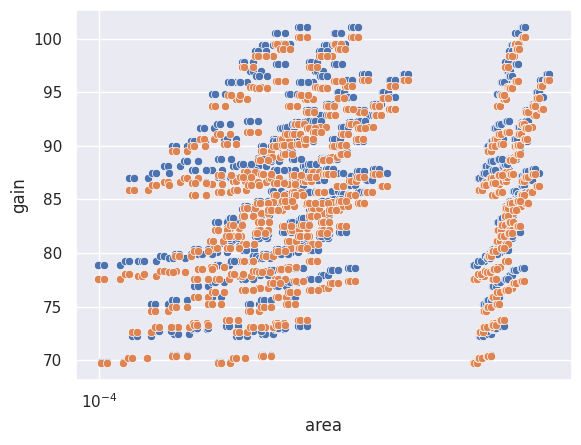

In [70]:
sns.scatterplot(data=ota_df, x="area", y="gain")
sns.scatterplot(data=ota_df_wc, x="area", y="gain")
plt.xscale("log")

In [71]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["gain_1stage"] = 20*np.log10(ota_df[Symbol("Ra_1stage")]*ota_df[Symbol("gma_1stage")])
ota_df["gain_2stage"] = 20*np.log10(ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("gma_2stage")])
ota_df["bw"] = 1/(2*np.pi*ota_df[Symbol("Ra_1stage")]*(ota_df[Symbol("Cin_2stage")]+ota_df[Symbol("gma_2stage")]*ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("Cc")]))

ota_df["bw_2"] = 1/(2*np.pi*ota_df[Symbol("Ra_1stage")]*Cin_pt)

ota_df["bw_wc"] = 1/(2*np.pi*ota_df_wc[Symbol("Ra_1stage")]*(ota_df_wc[Symbol("Cin_2stage")]+ota_df_wc[Symbol("gma_2stage")]*ota_df_wc[Symbol("Ra_2stage")]*ota_df_wc[Symbol("Cc")]))

#ota_df["phase_margin_OTA_wc"] = ota_df_wc["phase_margin_OTA"]

ota_df_wc["gain"] =  20*np.log10(ota_df_wc["gain_OTA"])

ota_df_new = ota_df[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44)) | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33))]
ota_df_wc_new = ota_df_wc[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44)) | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33))]

ota_df_new.sort_values(by="gain")

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
838    6.703565e+05    0.000116  1.346076e-14  6.739734e+05    0.000110   
841    6.703565e+05    0.000116  1.346076e-14  6.739734e+05    0.000110   
844    6.703565e+05    0.000116  1.346076e-14  6.739734e+05    0.000110   
49444  6.703565e+05    0.000116  1.346076e-14  7.089541e+05    0.000110   
49438  6.703565e+05    0.000116  1.346076e-14  7.089541e+05    0.000110   
...             ...         ...           ...           ...         ...   
17941  2.480966e+06    0.000122  6.353348e-14  1.598930e+06    0.000114   
17944  2.480966e+06    0.000122  6.353348e-14  1.598930e+06    0.000114   
26836  2.625481e+06    0.000118  2.629607e-13  1.598937e+06    0.000114   
26830  2.625481e+06    0.000118  2.629607e-13  1.598937e+06    0.000114   
26833  2.625481e+06    0.000118  2.629607e-13  1.598937e+06    0.000114   

                 Cc        Rc      gain_OTA      rout_OTA    gm_OTA  ...  \
838    3.162278e-12    1000.0   5763.224834  6.703565e+05  0.008597  ...   
841    3.162278e-12   10000.0   5763.224834  6.703565e+05  0.008597  ...   
844    3.162278e-12  100000.0   5763.224834  6.703565e+05  0.008597  ...   
49444  3.162278e-12  100000.0   6063.254299  6.703565e+05  0.009045  ...   
49438  3.162278e-12    1000.0   6063.254299  6.703565e+05  0.009045  ...   
...             ...       ...           ...           ...       ...  ...   
17941  3.162278e-12   10000.0  55262.118417  2.480966e+06  0.022274  ...   
17944  3.162278e-12  100000.0  55262.118417  2.480966e+06  0.022274  ...   
26836  3.162278e-12  100000.0  56357.486611  2.625481e+06  0.021466  ...   
26830  3.162278e-12    1000.0  56357.486611  2.625481e+06  0.021466  ...   
26833  3.162278e-12   10000.0  56357.486611  2.625481e+06  0.021466  ...   

           W_rc          L_rc      area       gain    gain_wc  gain_1stage  \
838    0.000001  5.000000e-07  0.000204  75.213311  74.548475    37.413428   
841    0.000004  5.000000e-07  0.000207  75.213311  74.548475    37.413428   
844    0.000012  5.000000e-07  0.000215  75.213311  74.548475    37.413428   
49444  0.000012  5.000000e-07  0.000228  75.654116  74.987414    37.854232   
49438  0.000001  5.000000e-07  0.000217  75.654116  74.987414    37.854232   
...         ...           ...       ...        ...        ...          ...   
17941  0.000004  5.000000e-07  0.000250  94.848551  93.695942    45.220903   
17944  0.000012  5.000000e-07  0.000258  94.848551  93.695942    45.220903   
26836  0.000012  5.000000e-07  0.000399  95.019032  94.484745    45.220891   
26830  0.000001  5.000000e-07  0.000388  95.019032  94.484745    45.220891   
26833  0.000004  5.000000e-07  0.000390  95.019032  94.484745    45.220891   

       gain_2stage          bw         bw_2        bw_wc  
838      37.799883  961.965209  4879.013196  1038.395280  
841      37.799883  961.965209  4879.013196  1038.395280  
844      37.799883  961.965209  4879.013196  1038.395280  
49444    37.799883  914.500720  4638.276977   987.372289  
49438    37.799883  914.500720  4638.276977   987.372289  
...            ...         ...          ...          ...  
17941    49.627648  103.891378  2056.578657   118.630953  
17944    49.627648  103.891378  2056.578657   118.630953  
26836    49.798141  101.850902  2056.569779   108.306162  
26830    49.798141  101.850902  2056.569779   108.306162  
26833    49.798141  101.850902  2056.569779   108.306162  

[258 rows x 36 columns]

/tmp/ipykernel_49141/4168062300.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'upper right')


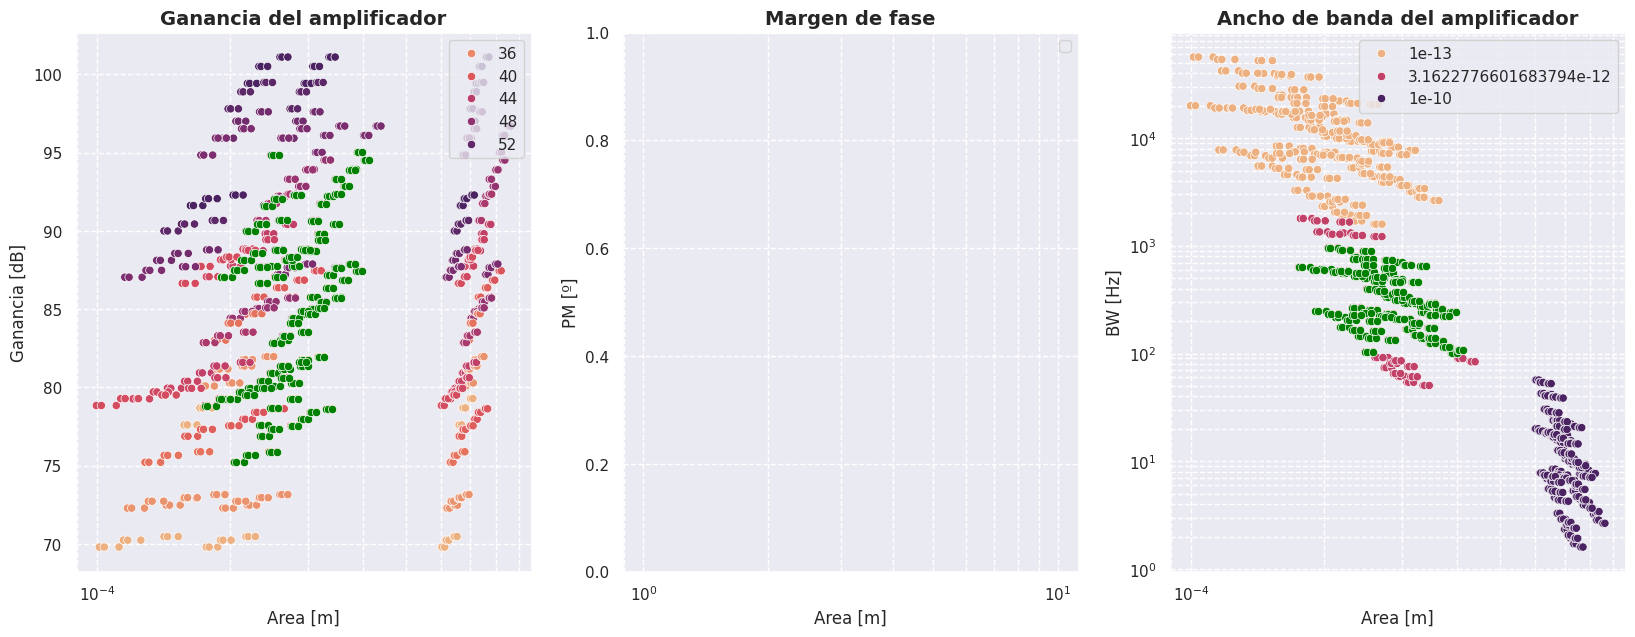

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare', hue="gain_2stage")
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green")
#sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA", hue="phase_margin_OTA_wc", palette='flare')
#sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA", color="green")
sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue=Symbol("Cc"), hue_norm=LogNorm(), palette='flare')
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Area [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Area [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")

plt.savefig('ota_explore_raw_3.svg', dpi=120)

In [73]:
ota_df_new.to_csv("data/GF_lv_ota_exploration3_case1_98_10_10.csv")
ota_df_wc_new.to_csv("data/GF_lv_ota_exploration3_case2_98_10_10.csv")

In [74]:
OTA_2stage_primitive_wc = Primitive(parameters={Symbol("Ra_2stage"): ota_df_wc[Symbol("Ra_2stage")].values,
                                  Symbol("gma_2stage"): ota_df_wc[Symbol("gma_2stage")].values,
                                  Symbol("Cin_2stage"): ota_df_wc[Symbol("Cin_2stage")].values,

                                  Symbol("Ra_1stage"): ota_df_wc[Symbol("Ra_1stage")].values,
                                  Symbol("gma_1stage"): ota_df_wc[Symbol("gma_1stage")].values,

                                  Symbol("Cc"): ota_df_wc[Symbol("Cc")].values,
                                  Symbol("Rc"): ota_df_wc[Symbol("Rc")].values,})

OTA_2stage_primitive_wc.outputs = {
    Symbol("W_2stage"): ota_df_wc[Symbol("W_2stage")].values,
    Symbol("L_2stage"): ota_df_wc[Symbol("L_2stage")].values,
    Symbol("vin_2stage"): ota_df_wc[Symbol("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df_wc[Symbol("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df_wc[Symbol("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df_wc[Symbol("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df_wc[Symbol("W_diff")].values,
    Symbol("L_diff"): ota_df_wc[Symbol("L_diff")].values,
    Symbol("vout_1stage"): ota_df_wc[Symbol("vout_1stage")].values,
    Symbol("W_al"): ota_df_wc[Symbol("W_al")].values,
    Symbol("L_al"): ota_df_wc[Symbol("L_al")].values,
    Symbol("W_cs"): ota_df_wc[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_wc[Symbol("L_cs")].values,
    Symbol("vgs_cs"): ota_df_wc[Symbol("vgs_cs")].values,
    
    Symbol("W_cc"): ota_df_wc[Symbol("W_cc")].values,
    Symbol("L_cc"): ota_df_wc[Symbol("L_cc")].values,
    
    Symbol("W_rc"): ota_df_wc[Symbol("W_rc")].values,
    Symbol("L_rc"): ota_df_wc[Symbol("L_rc")].values}

In [75]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt_wc}    

OTA_macro.ext_mask = None

OTA_macro.primitives = [OTA_2stage_primitive_wc]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA, phase_margin_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, mask_ota = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage
Running MNA... 
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7fb26b771900>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([8.87998541e-06, 8.87998541e-06, 8.87998541e-06, 8.87998541e-06,
       8.87998541e-06, 8.87998541

In [76]:
OTA_2stage_primitive = Primitive(parameters={Symbol("Ra_2stage"): ota_df[Symbol("Ra_2stage")].values,
                                  Symbol("gma_2stage"): ota_df[Symbol("gma_2stage")].values,
                                  Symbol("Cin_2stage"): ota_df[Symbol("Cin_2stage")].values,

                                  Symbol("Ra_1stage"): ota_df[Symbol("Ra_1stage")].values,
                                  Symbol("gma_1stage"): ota_df[Symbol("gma_1stage")].values,

                                  Symbol("Cc"): ota_df[Symbol("Cc")].values,
                                  Symbol("Rc"): ota_df[Symbol("Rc")].values,})
OTA_2stage_primitive.outputs = {
    Symbol("W_2stage"): ota_df[Symbol("W_2stage")].values,
    Symbol("L_2stage"): ota_df[Symbol("L_2stage")].values,
    Symbol("vin_2stage"): ota_df[Symbol("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df[Symbol("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df[Symbol("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df[Symbol("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df[Symbol("W_diff")].values,
    Symbol("L_diff"): ota_df[Symbol("L_diff")].values,
    Symbol("vout_1stage"): ota_df[Symbol("vout_1stage")].values,
    Symbol("W_al"): ota_df[Symbol("W_al")].values,
    Symbol("L_al"): ota_df[Symbol("L_al")].values,
    Symbol("W_cs"): ota_df[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df[Symbol("L_cs")].values,
    Symbol("vgs_cs"): ota_df[Symbol("vgs_cs")].values,
    
    Symbol("W_cc"): ota_df[Symbol("W_cc")].values,
    Symbol("L_cc"): ota_df[Symbol("L_cc")].values,
    
    Symbol("W_rc"): ota_df[Symbol("W_rc")].values,
    Symbol("L_rc"): ota_df[Symbol("L_rc")].values}

In [77]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt}    

OTA_macro.ext_mask = mask_ota

OTA_macro.primitives = [OTA_2stage_primitive]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA, phase_margin_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage
Running MNA... 
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7fb26ad33910>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([8.87998541e-06, 8.87998541e-06, 8.87998541e-06, 8.87998541e-06,
       8.87998541e-06, 8.87998541

In [78]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["gain_1stage"] = 20*np.log10(ota_df[Symbol("Ra_1stage")]*ota_df[Symbol("gma_1stage")])
ota_df["gain_2stage"] = 20*np.log10(ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("gma_2stage")])
ota_df["bw"] = 1/(2*np.pi*ota_df[Symbol("Ra_1stage")]*(ota_df[Symbol("Cin_2stage")]+ota_df[Symbol("gma_2stage")]*ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("Cc")]))

ota_df["bw_wc"] = 1/(2*np.pi*ota_df_wc[Symbol("Ra_1stage")]*(ota_df_wc[Symbol("Cin_2stage")]+ota_df_wc[Symbol("gma_2stage")]*ota_df_wc[Symbol("Ra_2stage")]*ota_df_wc[Symbol("Cc")]))

ota_df["phase_margin_OTA_wc"] = ota_df_wc["phase_margin_OTA"]

ota_df_wc["gain"] =  20*np.log10(ota_df_wc["gain_OTA"])

ota_df_new = ota_df[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80)) 
                                                        | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80))]
ota_df_wc_new = ota_df_wc[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80)) 
                                                        | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80))]

ota_df_new.sort_values(by="gain")

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
16   6.703565e+05    0.000116  1.346076e-14  6.739734e+05    0.000110   
340  6.703565e+05    0.000116  1.346076e-14  7.089541e+05    0.000110   
664  6.703565e+05    0.000116  1.346076e-14  7.279236e+05    0.000110   
25   8.117082e+05    0.000116  1.346076e-14  6.739876e+05    0.000110   
349  8.117082e+05    0.000116  1.346076e-14  7.089695e+05    0.000110   
673  8.117082e+05    0.000116  1.346076e-14  7.279398e+05    0.000110   
61   3.591349e+05    0.000116  1.346076e-14  1.598871e+06    0.000114   
34   9.198483e+05    0.000116  1.346076e-14  6.739944e+05    0.000110   
358  9.198483e+05    0.000116  1.346076e-14  7.089770e+05    0.000110   
682  9.198483e+05    0.000116  1.346076e-14  7.279477e+05    0.000110   
385  3.591349e+05    0.000116  1.346076e-14  1.810835e+06    0.000114   
43   1.017716e+06    0.000116  1.346076e-14  6.739860e+05    0.000110   
52   1.068980e+06    0.000116  1.346076e-14  6.739931e+05    0.000110   
367  1.017716e+06    0.000116  1.346076e-14  7.089678e+05    0.000110   
709  3.591349e+05    0.000116  1.346076e-14  1.939845e+06    0.000114   
691  1.017716e+06    0.000116  1.346076e-14  7.279380e+05    0.000110   
376  1.068980e+06    0.000116  1.346076e-14  7.089755e+05    0.000110   
700  1.068980e+06    0.000116  1.346076e-14  7.279461e+05    0.000110   
124  1.096227e+06    0.000122  6.353348e-14  6.739734e+05    0.000110   
448  1.096227e+06    0.000122  6.353348e-14  7.089541e+05    0.000110   
772  1.096227e+06    0.000122  6.353348e-14  7.279236e+05    0.000110   
133  1.532694e+06    0.000122  6.353348e-14  6.739876e+05    0.000110   
70   6.703565e+05    0.000116  1.346076e-14  1.598920e+06    0.000114   
457  1.532694e+06    0.000122  6.353348e-14  7.089695e+05    0.000110   
781  1.532694e+06    0.000122  6.353348e-14  7.279398e+05    0.000110   
394  6.703565e+05    0.000116  1.346076e-14  1.810892e+06    0.000114   
79   8.117082e+05    0.000116  1.346076e-14  1.598931e+06    0.000114   
718  6.703565e+05    0.000116  1.346076e-14  1.939907e+06    0.000114   
142  1.970009e+06    0.000122  6.353348e-14  6.739944e+05    0.000110   
466  1.970009e+06    0.000122  6.353348e-14  7.089770e+05    0.000110   
790  1.970009e+06    0.000122  6.353348e-14  7.279477e+05    0.000110   
403  8.117082e+05    0.000116  1.346076e-14  1.810905e+06    0.000114   
88   9.198483e+05    0.000116  1.346076e-14  1.598937e+06    0.000114   
727  8.117082e+05    0.000116  1.346076e-14  1.939922e+06    0.000114   
97   1.017716e+06    0.000116  1.346076e-14  1.598930e+06    0.000114   
412  9.198483e+05    0.000116  1.346076e-14  1.810912e+06    0.000114   
151  2.480966e+06    0.000122  6.353348e-14  6.739860e+05    0.000110   
106  1.068980e+06    0.000116  1.346076e-14  1.598936e+06    0.000114   
736  9.198483e+05    0.000116  1.346076e-14  1.939929e+06    0.000114   
475  2.480966e+06    0.000122  6.353348e-14  7.089678e+05    0.000110   
799  2.480966e+06    0.000122  6.353348e-14  7.279380e+05    0.000110   
421  1.017716e+06    0.000116  1.346076e-14  1.810904e+06    0.000114   
160  2.809407e+06    0.000122  6.353348e-14  6.739931e+05    0.000110   
430  1.068980e+06    0.000116  1.346076e-14  1.810911e+06    0.000114   
745  1.017716e+06    0.000116  1.346076e-14  1.939920e+06    0.000114   
484  2.809407e+06    0.000122  6.353348e-14  7.089755e+05    0.000110   
754  1.068980e+06    0.000116  1.346076e-14  1.939928e+06    0.000114   
808  2.809407e+06    0.000122  6.353348e-14  7.279461e+05    0.000110   

               Cc        Rc      gain_OTA      rout_OTA    gm_OTA  ...  \
16   3.162278e-12  100000.0   5763.224834  6.703565e+05  0.008597  ...   
340  3.162278e-12  100000.0   6063.254299  6.703565e+05  0.009045  ...   
664  3.162278e-12  100000.0   6225.812155  6.703565e+05  0.009287  ...   
25   3.162278e-12  100000.0   6978.444025  8.117082e+05  0.008597  ...   
349  3.162278e-12  100000.0   7341.745083  8.117082e+05  0.0

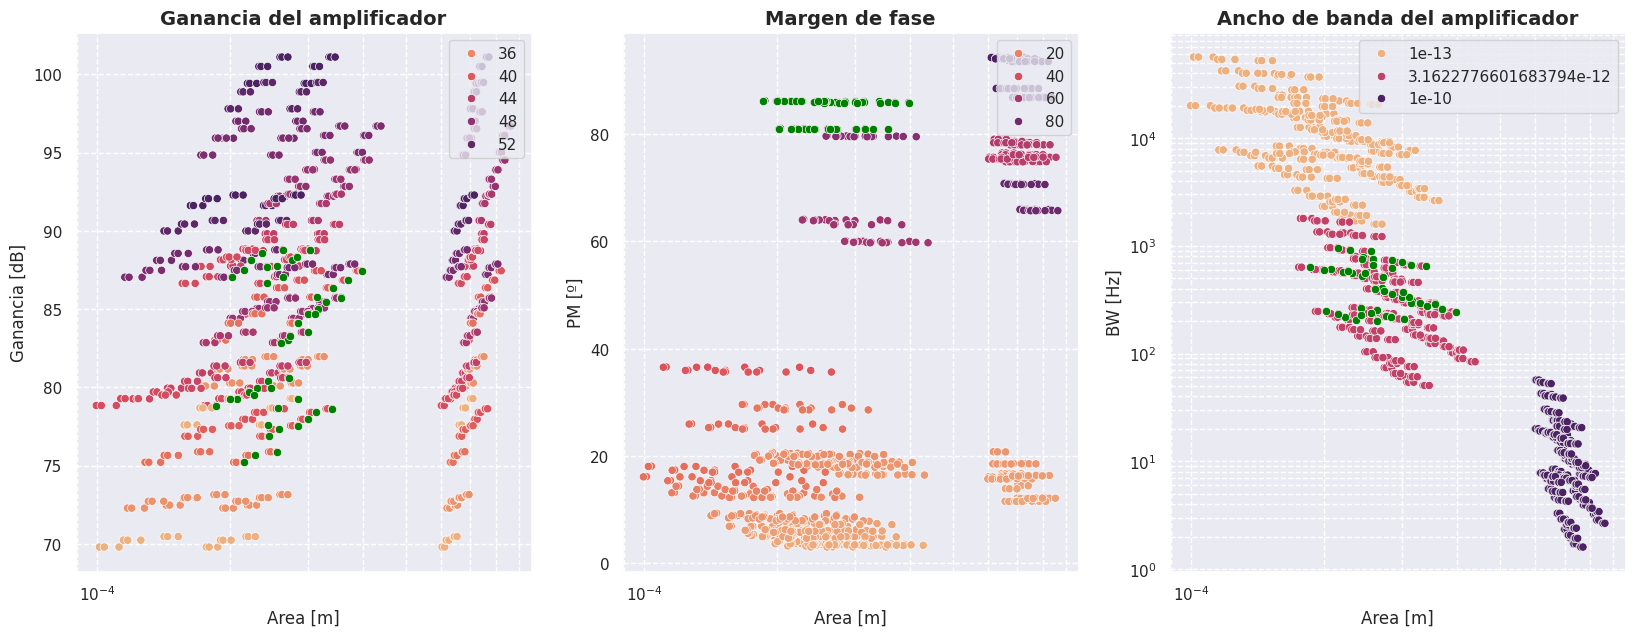

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare', hue="gain_2stage")
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green")
sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA", hue="phase_margin_OTA_wc", palette='flare')
sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA", color="green")
sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue=Symbol("Cc"), hue_norm=LogNorm(), palette='flare')
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Area [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Area [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")

plt.savefig('ota_explore_raw_3_sky.pdf')

# LDO

In [80]:
ota_df_new = pd.read_csv("data/GF_lv_ota_exploration3_case1_98_10_10.csv")
ota_df_wc_new = pd.read_csv("data/GF_lv_ota_exploration3_case2_98_10_10.csv")

In [81]:
OTA_primitive_wc = Primitive(
    parameters={
        Symbol("Ra"): ota_df_wc_new["rout_OTA"].values,
        Symbol("gma"): ota_df_wc_new["gm_OTA"].values,
        Symbol("Ra_1stage"): ota_df_wc_new[("Ra_1stage")].values,
        Symbol("gma_1stage"): ota_df_wc_new[("gma_1stage")].values,
        Symbol("Ra_2stage"): ota_df_wc_new[("Ra_2stage")].values,
        Symbol("gma_2stage"): ota_df_wc_new[("gma_2stage")].values,
        Symbol("Cin_2stage"): ota_df_wc_new[("Cin_2stage")].values,
        Symbol("Rc_2stage"): ota_df_wc_new[("Rc")].values,
        Symbol("Cc_2stage"): ota_df_wc_new[("Cc")].values,
    }
)

OTA_primitive_wc.outputs = {
    Symbol("W_2stage"): ota_df_wc_new[("W_2stage")].values,
    Symbol("L_2stage"): ota_df_wc_new[("L_2stage")].values,
    Symbol("vin_2stage"): ota_df_wc_new[("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df_wc_new[("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df_wc_new[("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df_wc_new[("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df_wc_new[("W_diff")].values,
    Symbol("L_diff"): ota_df_wc_new[("L_diff")].values,
    Symbol("vout_1stage"): ota_df_wc_new[("vout_1stage")].values,
    Symbol("W_al"): ota_df_wc_new[("W_al")].values,
    Symbol("L_al"): ota_df_wc_new[("L_al")].values,
    Symbol("W_cs"): ota_df_wc_new[("W_cs")].values,
    Symbol("L_cs"): ota_df_wc_new[("L_cs")].values,
    Symbol("vgs_cs"): ota_df_wc_new[("vgs_cs")].values,
}

In [89]:
ldo_df_new

Unnamed: 0            Ra       gma     gm_pt        Ro_pt        Cgg_pt  \
7427        7427  1.000000e+07  0.000215  0.026663  1767.563591  1.202241e-12   
7463        7463  1.000000e+07  0.000215  0.026663  1767.563591  1.202241e-12   
7481        7481  1.000000e+07  0.000215  0.026663  1767.563591  1.202241e-12   
8885        8885  3.593814e+06  0.000464  0.026663  1767.563591  1.202241e-12   
8939        8939  3.593814e+06  0.000464  0.026663  1767.563591  1.202241e-12   
9047        9047  1.000000e+07  0.000464  0.026663  1767.563591  1.202241e-12   
9101        9101  1.000000e+07  0.000464  0.026663  1767.563591  1.202241e-12   

            Cgd_pt        Cin_pt   dropout      Vota  ...  gain_ol_wc  \
7427  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   93.111127   
7463  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   93.111127   
7481  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   93.111127   
8885  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   90.888905   
8939  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   90.888905   
9047  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   99.777794   
9101  2.239119e-15  1.307769e-12  0.380671  0.688889  ...   99.777794   

       Vota_wc     cin_pt_wc      gmid  phase_margin_LDO_wc   loadreg  \
7427  1.057873  1.164183e-12  5.253882            80.103482  0.030273   
7463  1.057873  1.164183e-12  5.253882            61.872272  0.030273   
7481  1.057873  1.164183e-12  5.253882           101.952820  0.030273   
8885  1.057873  1.164183e-12  5.253882            70.655650  0.039111   
8939  1.057873  1.164183e-12  5.253882            79.774381  0.039111   
9047  1.057873  1.164183e-12  5.253882            70.651647  0.014044   
9101  1.057873  1.164183e-12  5.253882            79.767492  0.014044   

              bw   gain_ota             C          C_wc  
7427  328.580560  66.666667  4.843711e-11  1.415961e-10  
7463  981.748468  66.666667  1.621138e-11  4.557264e-11  
7481  328.580560  66.666667  4.843711e-11  1.415961e-10  
8885  914.294927  64.444444  4.843711e-11  1.415961e-10  
8939  914.294927  64.444444  4.843711e-11  1.415961e-10  
9047  328.580560  73.333333  4.843711e-11  1.415961e-10  
9101  328.580560  73.333333  4.843711e-11  1.415961e-10  

[7 rows x 36 columns]

In [90]:
ldo_df_wc_new

Unnamed: 0            Ra       gma     gm_pt         Ro_pt  \
7427        7427  1.000000e+07  0.000215  0.001543  90994.802354   
7463        7463  1.000000e+07  0.000215  0.001543  90994.802354   
7481        7481  1.000000e+07  0.000215  0.001543  90994.802354   
8885        8885  3.593814e+06  0.000464  0.001543  90994.802354   
8939        8939  3.593814e+06  0.000464  0.001543  90994.802354   
9047        9047  1.000000e+07  0.000464  0.001543  90994.802354   
9101        9101  1.000000e+07  0.000464  0.001543  90994.802354   

            Cgg_pt        Cgd_pt   dropout        Cin_pt      Vota  ...  \
7427  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
7463  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
7481  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
8885  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
8939  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
9047  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   
9101  1.021080e-12  1.019020e-15  0.097195  1.164183e-12  1.057873  ...   

        dc_LDO   gain_ol_LDO  phase_margin_LDO      W_pt          L_pt  \
7427  2.201992  45243.517031         80.103482  0.000908  4.000000e-07   
7463  2.201992  45243.517031         61.872272  0.000908  4.000000e-07   
7481  2.201992  45243.517031        101.952820  0.000908  4.000000e-07   
8885  2.202573  35030.412114         70.655650  0.000908  4.000000e-07   
8939  2.202573  35030.412114         79.774381  0.000908  4.000000e-07   
9047  2.200925  97474.202592         70.651647  0.000908  4.000000e-07   
9101  2.200925  97474.202592         79.767492  0.000908  4.000000e-07   

          W_cc      L_cc      W_rc          L_rc      area  
7427  0.000026  0.000026  0.000001  5.000000e-07  0.000962  
7463  0.000015  0.000015  0.000002  5.000000e-07  0.000940  
7481  0.000026  0.000026  0.000002  5.000000e-07  0.000962  
8885  0.000026  0.000026  0.000001  5.000000e-07  0.000962  
8939  0.000026  0.000026  0.000002  5.000000e-07  0.000962  
9047  0.000026  0.000026  0.000001  5.000000e-07  0.000962  
9101  0.000026  0.000026  0.000002  5.000000e-07  0.000962  

[7 rows x 23 columns]

In [91]:
pt_2 = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.0266634512908571]),
        Symbol('Ro_pt'): np.asarray([1767.5635905016463]),
        Symbol("Cgg_pt"): np.asarray([1.2022408576105078e-12]),
        Symbol("Cgd_pt"): np.asarray([2.2391190852909668e-15]),
        Symbol("Cin_pt"): np.asarray([1.3077690750420409e-12]),
        Symbol("dropout"): np.asarray([0.3806709000001225]),
        Symbol('Vota'): np.asarray([0.6888888888888889])
    }
)

pt_2.outputs = {
    Symbol("W_pt"): np.asarray([0.0009077961345068]),
    Symbol("L_pt"): np.asarray([4e-7])
}

pt_2_wc = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.001543295686831]),
        Symbol('Ro_pt'): np.asarray([90994.8023538388]),
        Symbol("Cgg_pt"): np.asarray([1.0210799490783093e-12]),
        Symbol("Cgd_pt"): np.asarray([1.0190197779098047e-15]),
        Symbol("Cin_pt"): np.asarray([1.1641828183581444e-12]),
        Symbol("dropout"): np.asarray([0.0971945954880531]),
        Symbol('Vota'): np.asarray([1.057873324243474])
    }
)

pt_2_wc.outputs = {
    Symbol("W_pt"): np.asarray([0.0009077961345068]),
    Symbol("L_pt"): np.asarray([4e-7])
}

In [92]:
Cc_primitive_LDO_2 = Primitive(
    parameters={
        Symbol("Cc"): np.asarray([3.1622776601683798e-12, 1e-12, 3.1622e-12, 1e-12]),
        Symbol("Rc"): np.asarray([1000.0, 1000, 3162, 3162])
    }
)

Cc_primitive_LDO_2.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, 4)
}

In [95]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): 1000000000000,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol_pm"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

LDO_macro.ext_mask = None

LDO_macro.primitives = [OTA_primitive_wc, pt_2_wc, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df_wc, ldo_mask_wc = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  LDO_macro
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol_pm
Running MNA... 
   vss  vout  net1  vfb  net2  vol  net4  net3
0    0     1     2    3     4    5     6     7
[['vout', 'vol']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(1.6e+16*Ro_pt*gm_pt + 1.6e+16)/(1.2e+16*Ra*Ro_pt*gm_pt*gma + 1000000016000.0*Ro_pt + 1.6e+16)
lambdify variables: (Ra, gma, Ra_1stage, gma_1stage, Ra_2stage, gma_2stage, Cin_2stage, Rc_2stage, Cc_2stage, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, Cin_pt, dropout, Vota, Cc, Rc) <function _lambdifygenerated at 0x7fb2696c5480>
#### creating the primods_l

In [96]:
OTA_primitive = Primitive(
    parameters={
        Symbol("Ra"): ota_df_new["rout_OTA"],
        Symbol("gma"): ota_df_new["gm_OTA"],
        Symbol("Ra_1stage"): ota_df_new[("Ra_1stage")],
        Symbol("gma_1stage"): ota_df_new[("gma_1stage")],
        Symbol("Ra_2stage"): ota_df_new[("Ra_2stage")],
        Symbol("gma_2stage"): ota_df_new[("gma_2stage")],
        Symbol("Cin_2stage"): ota_df_new[("Cin_2stage")],
        Symbol("Rc_2stage"): ota_df_new[("Rc")],
        Symbol("Cc_2stage"): ota_df_new[("Cc")],
    }
)

OTA_primitive.outputs = {
    Symbol("W_2stage"): ota_df_new[("W_2stage")].values,
    Symbol("L_2stage"): ota_df_new[("L_2stage")].values,
    Symbol("vin_2stage"): ota_df_new[("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df_new[("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df_new[("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df_new[("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df_new[("W_diff")].values,
    Symbol("L_diff"): ota_df_new[("L_diff")].values,
    Symbol("vout_1stage"): ota_df_new[("vout_1stage")].values,
    Symbol("W_al"): ota_df_new[("W_al")].values,
    Symbol("L_al"): ota_df_new[("L_al")].values,
    Symbol("W_cs"): ota_df_new[("W_cs")].values,
    Symbol("L_cs"): ota_df_new[("L_cs")].values,
    Symbol("vgs_cs"): ota_df_new[("vgs_cs")].values,
}

In [97]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol_pm"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}


LDO_macro.ext_mask = ldo_mask_wc

LDO_macro.primitives = [OTA_primitive, pt_2, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_ol_pm
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol_pm
Running MNA... 
   vss  vout  net1  vfb  net2  vol  net4  net3
0    0     1     2    3     4    5     6     7
[['vout', 'vol']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(3840000.0*Ro_pt*gm_pt + 3840000.0)/(2880000.0*Ra*Ro_pt*gm_pt*gma + 16240.0*Ro_pt + 3840000.0)
lambdify variables: (Ra, gma, Ra_1stage, gma_1stage, Ra_2stage, gma_2stage, Cin_2stage, Rc_2stage, Cc_2stage, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, Cin_pt, dropout, Vota, Cc, Rc) <function _lambdifygenerated at 0x7fb26972b6d0>
#### creating the primods_l

In [98]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["gain_ol"] = 20*np.log10(ldo_df["gain_ol_LDO"])  
ldo_df_new = ldo_df[(ldo_df[Symbol("dropout")]<0.4) & (ldo_df["phase_margin_LDO"]>10) & (ldo_df["phase_margin_LDO"]<100)]
ldo_df_new

Ra       gma     Ra_1stage  gma_1stage     Ra_2stage  \
4     6.703565e+05  0.008597  6.739734e+05    0.000110  6.703565e+05   
5     6.703565e+05  0.008597  6.739734e+05    0.000110  6.703565e+05   
6     6.703565e+05  0.008597  6.739734e+05    0.000110  6.703565e+05   
7     6.703565e+05  0.008597  6.739734e+05    0.000110  6.703565e+05   
9     6.703565e+05  0.008597  6.739734e+05    0.000110  6.703565e+05   
...            ...       ...           ...         ...           ...   
1027  1.902166e+06  0.026060  1.939922e+06    0.000114  1.902166e+06   
1028  1.902166e+06  0.026060  1.939922e+06    0.000114  1.902166e+06   
1029  1.902166e+06  0.026060  1.939922e+06    0.000114  1.902166e+06   
1030  1.902166e+06  0.026060  1.939922e+06    0.000114  1.902166e+06   
1031  1.902166e+06  0.026060  1.939922e+06    0.000114  1.902166e+06   

      gma_2stage    Cin_2stage  Rc_2stage     Cc_2stage     gm_pt  ...  \
4       0.000116  1.346076e-14    10000.0  3.162278e-12  0.026663  ...   
5       0.000116  1.346076e-14    10000.0  3.162278e-12  0.026663  ...   
6       0.000116  1.346076e-14    10000.0  3.162278e-12  0.026663  ...   
7       0.000116  1.346076e-14    10000.0  3.162278e-12  0.026663  ...   
9       0.000116  1.346076e-14   100000.0  3.162278e-12  0.026663  ...   
...          ...           ...        ...           ...       ...  ...   
1027    0.000118  2.629607e-13    10000.0  3.162278e-12  0.026663  ...   
1028    0.000118  2.629607e-13   100000.0  3.162278e-12  0.026663  ...   
1029    0.000118  2.629607e-13   100000.0  3.162278e-12  0.026663  ...   
1030    0.000118  2.629607e-13   100000.0  3.162278e-12  0.026663  ...   
1031    0.000118  2.629607e-13   100000.0  3.162278e-12  0.026663  ...   

      vgs_cs      W_pt          L_pt      W_cc      L_cc      W_rc  \
4        0.7  0.000908  4.000000e-07  0.000008  0.000008  0.000001   
5        0.7  0.000908  4.000000e-07  0.000015  0.000015  0.000001   
6        0.7  0.000908  4.000000e-07  0.000026  0.000026  0.000001   
7        0.7  0.000908  4.000000e-07  0.000008  0.000008  0.000002   
9        0.7  0.000908  4.000000e-07  0.000015  0.000015  0.000001   
...      ...       ...           ...       ...       ...       ...   
1027     0.7  0.000908  4.000000e-07  0.000008  0.000008  0.000002   
1028     0.7  0.000908  4.000000e-07  0.000008  0.000008  0.000001   
1029     0.7  0.000908  4.000000e-07  0.000015  0.000015  0.000001   
1030     0.7  0.000908  4.000000e-07  0.000026  0.000026  0.000001   
1031     0.7  0.000908  4.000000e-07  0.000008  0.000008  0.000002   

              L_rc      area       psrr     gain_ol  
4     5.000000e-07  0.001037 -72.532527   90.116016  
5     5.000000e-07  0.001049 -72.532527   90.116016  
6     5.000000e-07  0.001072 -72.532527   90.116016  
7     5.000000e-07  0.001038 -72.532527   90.116016  
9     5.000000e-07  0.001049 -72.532527   90.116016  
...            ...       ...        ...         ...  
1027  5.000000e-07  0.001206 -91.223350  108.807159  
1028  5.000000e-07  0.001205 -91.223350  108.807159  
1029  5.000000e-07  0.001218 -91.223350  108.807159  
1030  5.000000e-07  0.001240 -91.223350  108.807159  
1031  5.000000e-07  0.001206 -91.223350  108.807159  

[655 rows x 45 columns]

In [106]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["psrr_wc"] = 20*np.log10(ldo_df_wc["psrr_LDO"])

ldo_df['gain_ol'] = 20*np.log10(ldo_df['gain_ol_LDO'])
ldo_df['gain_ol_wc'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

ldo_df["Vota_wc"] = ldo_df_wc[Symbol("Vota")]
ldo_df["cin_pt_wc"] = ldo_df_wc[Symbol("Cin_pt")]

ldo_df['gmid'] = ldo_df[Symbol('gm_pt')]/pt.inputs['il']

ldo_df["phase_margin_LDO_wc"] = ldo_df_wc["phase_margin_LDO"]

ldo_df['loadreg'] = np.abs(ldo_df['dc_LDO']-ldo_df_wc['dc_LDO'])/IL

ldo_df["bw"] = 1/(2*np.pi*ldo_df[Symbol("Ra_1stage")]*(ldo_df[Symbol("Cin_pt")]+ldo_df[Symbol("gma_2stage")]*ldo_df[Symbol("Ra_2stage")]*ldo_df[Symbol("Cc_2stage")]))    
ldo_df["gain_ota"] = 20*np.log10(ldo_df[Symbol("Ra")]*ldo_df[Symbol("gma")])

#ldo_df = ldo_df[(ldo_df["gain_ota"]>20) & (ldo_df[Symbol("W_pt")]<0.6e-3) & (ldo_df[Symbol("dropout")]<0.4)]

ldo_df_new = ldo_df[((ldo_df[Symbol("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>10) & (ldo_df[Symbol("W_pt")]<1e-3))]
#ldo_df_new = ldo_df
ldo_df_new.sort_values(by="area")

Ra       gma     Ra_1stage  gma_1stage     Ra_2stage  \
44   1.017716e+06  0.008597  6.739860e+05    0.000110  1.017716e+06   
404  1.017716e+06  0.009045  7.089678e+05    0.000110  1.017716e+06   
56   1.068980e+06  0.008597  6.739931e+05    0.000110  1.068980e+06   
8    6.703565e+05  0.008597  6.739734e+05    0.000110  6.703565e+05   
416  1.068980e+06  0.009045  7.089755e+05    0.000110  1.068980e+06   
740  1.017716e+06  0.009287  7.279380e+05    0.000110  1.017716e+06   
368  6.703565e+05  0.009045  7.089541e+05    0.000110  6.703565e+05   
178  2.480966e+06  0.009066  6.739860e+05    0.000110  2.480966e+06   
116  1.017716e+06  0.021122  1.598930e+06    0.000114  1.017716e+06   
68   3.591349e+05  0.021122  1.598871e+06    0.000114  3.591349e+05   
20   8.117082e+05  0.008597  6.739876e+05    0.000110  8.117082e+05   
752  1.068980e+06  0.009287  7.279461e+05    0.000110  1.068980e+06   
538  2.480966e+06  0.009538  7.089678e+05    0.000110  2.480966e+06   
704  6.703565e+05  0.009287  7.279236e+05    0.000110  6.703565e+05   
476  1.017716e+06  0.023932  1.810904e+06    0.000114  1.017716e+06   
428  3.591349e+05  0.023932  1.810835e+06    0.000114  3.591349e+05   
380  8.117082e+05  0.009045  7.089695e+05    0.000110  8.117082e+05   
190  2.809407e+06  0.009066  6.739931e+05    0.000110  2.809407e+06   
128  1.068980e+06  0.021122  1.598936e+06    0.000114  1.068980e+06   
142  1.096227e+06  0.009066  6.739734e+05    0.000110  1.096227e+06   
80   6.703565e+05  0.021122  1.598920e+06    0.000114  6.703565e+05   
550  2.809407e+06  0.009538  7.089755e+05    0.000110  2.809407e+06   
488  1.068980e+06  0.023932  1.810911e+06    0.000114  1.068980e+06   
874  2.480966e+06  0.009794  7.279380e+05    0.000110  2.480966e+06   
502  1.096227e+06  0.009538  7.089541e+05    0.000110  1.096227e+06   
812  1.017716e+06  0.025643  1.939920e+06    0.000114  1.017716e+06   
764  3.591349e+05  0.025643  1.939845e+06    0.000114  3.591349e+05   
440  6.703565e+05  0.023932  1.810892e+06    0.000114  6.703565e+05   
716  8.117082e+05  0.009287  7.279398e+05    0.000110  8.117082e+05   
250  2.480966e+06  0.022274  1.598930e+06    0.000114  2.480966e+06   
202  4.535261e+05  0.022275  1.598871e+06    0.000114  4.535261e+05   
154  1.532694e+06  0.009066  6.739876e+05    0.000110  1.532694e+06   
886  2.809407e+06  0.009794  7.279461e+05    0.000110  2.809407e+06   
32   9.198483e+05  0.008597  6.739944e+05    0.000110  9.198483e+05   
92   8.117082e+05  0.021122  1.598931e+06    0.000114  8.117082e+05   
824  1.068980e+06  0.025643  1.939928e+06    0.000114  1.068980e+06   
838  1.096227e+06  0.009794  7.279236e+05    0.000110  1.096227e+06   
562  4.535261e+05  0.025238  1.810835e+06    0.000114  4.535261e+05   
514  1.532694e+06  0.009538  7.089695e+05    0.000110  1.532694e+06   
776  6.703565e+05  0.025643  1.939907e+06    0.000114  6.703565e+05   
392  9.198483e+05  0.009045  7.089770e+05    0.000110  9.198483e+05   
452  8.117082e+05  0.023932  1.810905e+06    0.000114  8.117082e+05   
214  1.096227e+06  0.022274  1.598920e+06    0.000114  1.096227e+06   
898  4.535261e+05  0.027042  1.939845e+06    0.000114  4.535261e+05   
574  1.096227e+06  0.025238  1.810892e+06    0.000114  1.096227e+06   
850  1.532694e+06  0.009794  7.279398e+05    0.000110  1.532694e+06   
728  9.198483e+05  0.009287  7.279477e+05    0.000110  9.198483e+05   
788  8.117082e+05  0.025643  1.939922e+06    0.000114  8.117082e+05   
166  1.970009e+06  0.009066  6.739944e+05    0.000110  1.970009e+06   
226  1.532694e+06  0.022274  1.598931e+06    0.000114  1.532694e+06   
104  9.198483e+05  0.021122  1.598937e+06    0.000114  9.198483e+05   
526  1.970009e+06  0.009538  7.089770e+05    0.000110  1.970009e+06   
464  9.198483e+05  0.023932  1.810912e+06    0.000114  9.198483e+05   
862  1.970009e+06  0.009794  7.279477e+05    0.000110  1.970009e+06   
800  9.198483e+05  0.025643  1.939929e+06    0.000114  9.198483e+05   
238  1.970009e+06  0.022274  1.598937e+

In [107]:
ldo_df_wc_new = ldo_df_wc[((ldo_df[Symbol("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>100) & (ldo_df[Symbol("W_pt")]<1e-3))]
ldo_df_wc_new['gain_ol'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

/tmp/ipykernel_49141/1631062507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldo_df_wc_new['gain_ol'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])


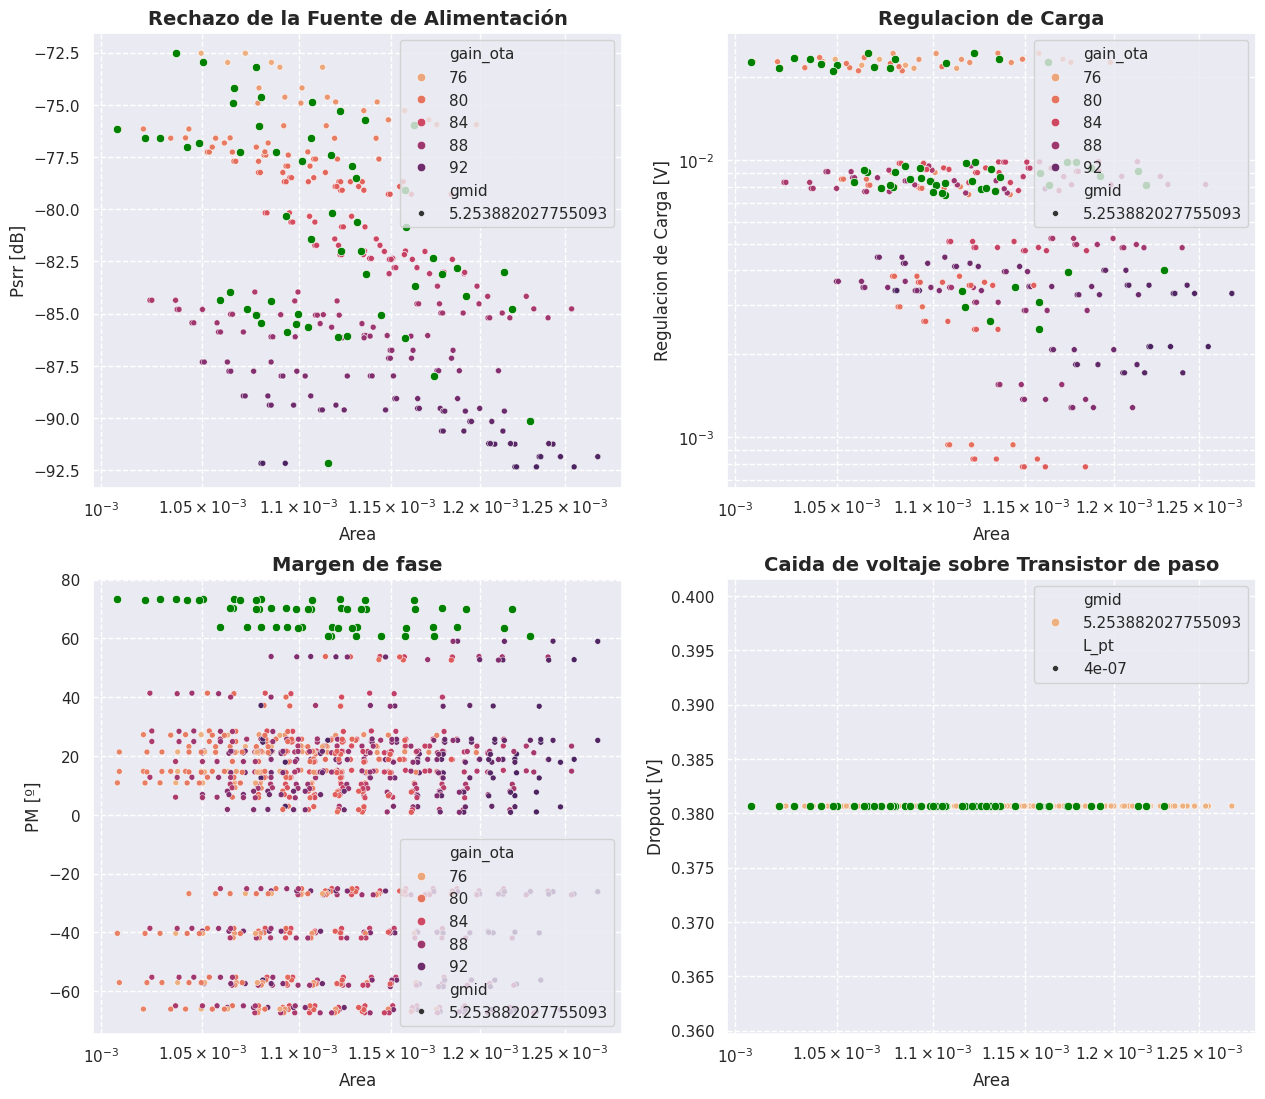

In [108]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=ldo_df, x='area', y='psrr', palette='flare', hue='gain_ota', rasterized=True, size='gmid')
sns.scatterplot(ax=axs[0,0], data=ldo_df_new, x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=ldo_df, x='area', y='loadreg', palette='flare', rasterized=True, hue='gain_ota', size='gmid')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new, x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=ldo_df, x='area', y=Symbol('dropout'), palette='flare', hue='gmid', rasterized=True, size=Symbol('L_pt'))
sns.scatterplot(ax=axs[1,1], data=ldo_df_new, x='area', y=Symbol('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=ldo_df, x='area', y="phase_margin_LDO_wc", palette='flare', hue="gain_ota", rasterized=True, size='gmid')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new, x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Area")
axs[0,0].set_ylabel(r"Psrr [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulacion de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Area")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Area")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caida de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Area")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "upper right")
sns.move_legend(axs[0,1], "upper right")
sns.move_legend(axs[1,0], "lower right")
sns.move_legend(axs[1,1], "upper right")

plt.savefig('ldo_explore_raw_2.pdf')